<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/FTS_Analysis_Interferomegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this file is an attempt at using an arbitrary list of frequencies for as the inputs the blackbody signal. This would resolve an issue where the total power is not correct due to different sized integration slices and separation between evaluation points. This file was created on April 16, 2020.

In [127]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
from scipy.signal import get_window
import numpy as np
from scipy.signal import find_peaks
from math import sqrt, sin
from cmath import pi
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline

In [128]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [129]:
import sys
sys.path.append('/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/')
from BlackbodyFunctions import *
from FTSFunctions import *

Motorized stage details (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2163): 


*   Max Velocity = 2.6 mm/s
*   Max Travel Range = 12mm (12e3 µm)
*   Minimum Step Size = 0.10 µm

Review this document for understanding of how FTS works/ data looks: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Fundamentals_of_Spectroscopy/The_Power_of_the_Fourier_Transform_for_Spectroscopists

In [130]:
#define some useful constants
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
mm_to_micron = 1000
nm_to_micron = 1/1000

#Fixed values for the run (note that jog_pause changes)
jog_dist = 0.0001 #mm
jog_speed = 2.6 #mm/s

noise_to_signal_ratio = 1e-7

#fixed value, the detector records 5 measurments per second
detector_time_stamp = 1/5 #measurments per second 

In [131]:
#fixed variables that we can use for generating the background blackbody signal
lambda_or_nu = False
min_frequency = 0.1 #THz
max_frequency = 1500 #THz
frequency_slice_size = 0.01  #THz 
frequencies = arange(frequency_slice_size, max_frequency, frequency_slice_size) #still in THz (use min as frequency slice size)

In [132]:
############Extract the temperature as a function of voltage information to input most accurate data into the blackbody simulation##########
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'
Si253_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual.csv")
Si253_temp_manual_1 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_1.csv")
Si253_temp_manual_2 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_2.csv")
Si253_temp_manual_3 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_3.csv")
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']
cleanedTempList = cleanedTempList[10:] #trim off the first 10 entries from this list because it started at 0.1 V rather than 1.1 V
cleanedVoltList = cleanedVoltList[10:] 
cleanedTempList_short_1 = [x for x in Si253_temp_manual_1['Temp'] if str(x) != 'nan']
cleanedTempList_short_2 = [x for x in Si253_temp_manual_2['Temp'] if str(x) != 'nan']
cleanedTempList_short_3 = [x for x in Si253_temp_manual_3['Temp'] if str(x) != 'nan']
cleanedVoltList_short = [x for x in Si253_temp_manual_1['Voltage'] if str(x) != 'nan']
cleanedTempList_short_0_extrapolate = interp1d(cleanedVoltList, cleanedTempList, fill_value='extrapolate')
cleanedTempList_short_1_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_1, fill_value='extrapolate')
cleanedTempList_short_2_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_2, fill_value='extrapolate')
cleanedTempList_short_3_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_3, fill_value='extrapolate')

def get_temp(volt, manual = False):
  if manual:
    #this returns the manually calculated temperautre value from data taken with thermal camera
    average_temp = (cleanedTempList_short_0_extrapolate(volt) + cleanedTempList_short_1_extrapolate(volt) + cleanedTempList_short_2_extrapolate(volt) + cleanedTempList_short_3_extrapolate(volt))/4
    return (average_temp)
  else: 
    # from the IR-Si253 voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-Si253-Series-formerly-IR-18-and-IR-19.pdf), were able to extract data points and fit to a polynomial using excel. 
    # The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
    # Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
    t =  -3.5727 * volt**2 + 136.61*volt + 294.53
    return t

In [133]:
def get_interferometer_data_auto(filtertype, jog_pause, detector_time_stamp=detector_time_stamp):
  cleaned_power = [x for x in d_0['power_' + filtertype] if str(x) != 'nan']
  time = np.arange(0,len(cleaned_power)*detector_time_stamp, detector_time_stamp) #a perfect time array (compensates for not always starting at 0 in real data), used for interpolating
  interpolate_power = interp1d(time[0:len(cleaned_power)], cleaned_power, fill_value='extrapolate') #interpolate the power to get inbetween data points

  #create an array that has measurments at ideal timestamps (dont want too many or this would probably ruin our error calcualtion, and make things look more accurate than they are)
  ideal_timestamp_spacing = 0.001  #want more measurments 
  ideal_time = np.arange(0,len(cleaned_power)*detector_time_stamp, ideal_timestamp_spacing)
  num_ideal_timesteps = jog_pause/ideal_timestamp_spacing
  n = int(round(num_ideal_timesteps))

  cleaned_power_ideal_timestamps= interpolate_power(ideal_time) ## an array of interpolated power values at the times we care about 
  #calcualte power and error (since we sit at some physical point in space for an extended time, we can average all power values taken at that physical position)
  power_averaged= [sum(cleaned_power_ideal_timestamps[i:i+n])/n for i in range(0,len(cleaned_power_ideal_timestamps),n)] #returns the avg of every n data points
  power_error = [sum((cleaned_power_ideal_timestamps[i:i+n] - power_averaged[j])**2)/n for i,j in zip(range(0,len(cleaned_power_ideal_timestamps),n), range(len(power_averaged)))] #returns the avg error of every n data points when averaged together 
  return power_averaged[0:len(power_error)], power_error


In [134]:
true_jog_pause = 1 #s
first_jog_pause = 0.5 #s (this is for very first measruments, of laser)
jog_adjustment = True
jog_adjustment_value = 0.9 #######this is the fraction that allowed us to have the best alignment of the laser peak in analysis of data to simulation
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/Interferogram_Playing/'

#####update controlled values for the run 
if jog_adjustment:
  jog_pause = true_jog_pause * jog_adjustment_value #s
  first_jog_pause = first_jog_pause * jog_adjustment_value #s
else:
  jog_pause = true_jog_pause
  first_jog_pause = first_jog_pause

Si253_noFilter_interferogram_9V_0 = pd.read_csv(folder_path + "07oct2020-noFiltIR9V-scan100nmSteps-2000steps-1secondPerStep-0950AM.csv")
Si253_noFilter_interferogram_9V = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1050AM-IR-Si253-9V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_9V_2 = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1520PM-IR-Si253-9V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_9V_3 = pd.read_csv(folder_path + "28oct2020_runs/26oct2020-1425PMthru1529PM-IR-Si253-9V-noFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_noFilter_interferogram_9V_4 = pd.read_csv(folder_path + "28oct2020_runs/23oct2020-0903AMthru1006AM-IR-Si253-9V-noFilter-100nmStepsPerSecond-3000steps.csv")

Si253_PEWFilter_interferogram_9V_0 = pd.read_csv(folder_path + "07oct2020-PEWIR9V-scan100nmSteps-2000steps-1secondPerStep-0859AM.csv")
Si253_PEWFilter_interferogram_9V = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1050AM-IR-Si253-9V-PEWfilter-100nmStepsPerSecond-3000steps.csv")
Si253_PEWFilter_interferogram_9V_2 = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1412PM-IR-Si253-9V-PEWfilter-100nmStepsPerSecond-3000steps.csv")
Si253_PEWFilter_interferogram_9V_3 = pd.read_csv(folder_path + "28oct2020_runs/26oct2020-1317PMthru1419PM-IR-Si253-9V-PEWfilter-100nmStepsPerSeconds-3000steps.csv")
Si253_PEWFilter_interferogram_9V_4 = pd.read_csv(folder_path + "28oct2020_runs/23oct2020-1719PMthru1822PM-IR-Si253-9V-PEWfilter-100nmStepsPerSecond-3000steps.csv")
Si253_PEWFilter_interferogram_9V_5 = pd.read_csv(folder_path + "28oct2020_runs/23oct2020-1609PMthru1712PM-IR-Si253-9V-PEWfilter-100nmStepsPerSecond-3000steps.csv")

Si253_SiWFilter_interferogram_9V = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-0940AM-IR-Si253-9V-SiWfilter-100nmStepsPerSecond-3000steps.csv")
Si253_SiWFilter_interferogram_9V_2 = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1305PM-IR-Si253-9V-SiWfilter-100nmStepsPerSecond-3000steps.csv")
Si253_SiWFilter_interferogram_9V_3 = pd.read_csv(folder_path + "28oct2020_runs/26oct2020-1647PMthru1552PM-IR-Si253-9V-SiWFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_SiWFilter_interferogram_9V_4 = pd.read_csv(folder_path + "28oct2020_runs/26oct2020-1542PMthru1645PM-IR-Si253-9V-SiWFilter-100nmStepsPerSeconds-3000steps.csv")

Si253_bagFilter_interferogram_9V = pd.read_csv(folder_path + "15oct2020_runs/15oct2020-1635PM-IR-Si253-9V-ClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_bagFilter_interferogram_9V_2 = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-0940PM-IR-Si253-9V-ClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_bagFilter_interferogram_9V_3 = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-1050PM-IR-Si253-9V-ClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_bagFilter_interferogram_5V = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-1211PMthru1314AM-IR-Si253-6p5V-plasticBagFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_bagFilter_interferogram_5V_2 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-1104AMthru1208AM-IR-Si253-6p5V-plasticBagFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_bagFilter_interferogram_5V_3 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-0957AMthru1100AM-IR-Si253-6p5V-plasticBagFilter-100nmStepsPerSeconds-3000steps.csv")

Si253_isopropanol_bagFilter_interferogram_9V = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-1300PM-IR-Si253-9V-IsopropanolInClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_isopropanol_bagFilter_interferogram_9V_2 = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-1405PM-IR-Si253-9V-IsopropanolInClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_isopropanol_bagFilter_interferogram_9V_3 = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-1510PM-IR-Si253-9V-IsopropanolInClearPlasticBagfilter-100nmStepsPerSecond-3000steps.csv")
Si253_5V_isopropanol_bagFilter_interferogram = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-1533PMthru1636PM-IR-Si253-6p5V-isopropanolInBagFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_5V_isopropanol_bagFilter_interferogram_2 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-1424PMthru1525PM-IR-Si253-6p5V-isopropanolInBagFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_5V_isopropanol_bagFilter_interferogram_3 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-0957AMthru1100AM-IR-Si253-6p5V-plasticBagFilter-100nmStepsPerSeconds-3000steps.csv")

Si253_1650nmBandPassFilter_interferogram_9V = pd.read_csv(folder_path + "16oct2020_runs/16oct2020-1630PM-IR-Si253-9V-1650nmBandPassFilter-100nmStepsPerSecond-3000steps.csv")
Si253_1650nmBandPassFilter_interferogram_9V_2 = pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1357PM-IR-Si253-9V-1650nmBandpassFilter-100nmStepsPerSecond-3000steps.csv")
Si253_1650nmBandPassFilter_interferogram_9V_3 = pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1505PM-IR-Si253-9V-1650nmBandpassFilter-100nmStepsPerSecond-3000steps.csv")
Si253_1650nmBandPassFilter_interferogram_9V_4 = pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1620PM-IR-Si253-9V-1650nmBandpassFilter-100nmStepsPerSecond-3000steps.csv")

Si253_noFilter_interferogram_3V =pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1245PM-IR-Si253-3V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_4V =pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1137PM-IR-Si253-4V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_5V =pd.read_csv(folder_path + "19-21oct2020_runs/19oct2020-1440PM-IR-Si253-5V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_5V_2 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-1316PMthru1420AM-IR-Si253-6p5V-noFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_noFilter_interferogram_5V_3 = pd.read_csv(folder_path + "28oct2020_runs/28oct2020-0849AMthru0953PM-IR-Si253-6p5V-noFilter-100nmStepsPerSeconds-3000steps.csv")
Si253_noFilter_interferogram_6V =pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-0922AM-IR-Si253-6V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_7V =pd.read_csv(folder_path + "19-21oct2020_runs/19oct2020-1545PM-IR-Si253-7V-Nofilter-100nmStepsPerSecond-3000steps.csv")
Si253_noFilter_interferogram_8V =pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1035AM-IR-Si253-8V-Nofilter-100nmStepsPerSecond-3000steps.csv")

noSource_noFilter_interferogram_9V = pd.read_csv(folder_path + "19-21oct2020_runs/20oct2020-1740PM-noSourceNoFilter-100nmStepsPerSecond-3000steps.csv")
noSource_noFilter_interferogram_9V_2 = pd.read_csv(folder_path + "19-21oct2020_runs/21oct2020-0745AM-noSourceNoFilter-100nmStepsPerSecond-3000steps.csv")
noSource_noFilter_interferogram_9V_3 = pd.read_csv(folder_path + "19-21oct2020_runs/21oct2020-0850AM-noSourceNoFilter-100nmStepsPerSecond-3000steps.csv")

laser635_noFilter_interferogram_00 = pd.read_csv(folder_path + "first_interferogram.csv")
laser635_noFilter_interferogram_0 = pd.read_csv(folder_path + "05oct2020-laser-scan100nmSteps-0p5secondsPerStep-2000steps-TRADbatchsize50-1423PM.csv")
laser635_noFilter_interferogram = pd.read_csv(folder_path + "28oct2020_runs/3nov2020-1130AMthru1154AM-635nmLaser-noFilter-100micronTravel.csv")
laser635_noFilter_interferogram_2 = pd.read_csv(folder_path + "28oct2020_runs/3nov2020-1100AMthru1124AM-635nmLaser-noFilter-100micronTravel.csv")
laser635_noFilter_interferogram_3 = pd.read_csv(folder_path + "28oct2020_runs/3nov2020-1031AMthru1056AM-635nmLaser-noFilter-100micronTravel.csv")


d_0 = {
    'power_nofilter_Si253_9V_0' : Si253_noFilter_interferogram_9V_0['Power'],
    'power_nofilter_Si253_9V' : Si253_noFilter_interferogram_9V['Power'],
    'power_nofilter_Si253_9V_2' : Si253_noFilter_interferogram_9V_2['Power'],
    'power_nofilter_Si253_9V_3' : Si253_noFilter_interferogram_9V_3['Power'],
    'power_nofilter_Si253_9V_4' : Si253_noFilter_interferogram_9V_4['Power'],

    'power_PEWfilter_Si253_9V_0' : Si253_PEWFilter_interferogram_9V_0['Power'],
    'power_PEWfilter_Si253_9V' : Si253_PEWFilter_interferogram_9V['Power'],
    'power_PEWfilter_Si253_9V_2' : Si253_PEWFilter_interferogram_9V_2['Power'],
    'power_PEWfilter_Si253_9V_3' : Si253_PEWFilter_interferogram_9V_3['Power'],
    'power_PEWfilter_Si253_9V_4' : Si253_PEWFilter_interferogram_9V_4['Power'],
    'power_PEWfilter_Si253_9V_5' : Si253_PEWFilter_interferogram_9V_5['Power'],

    'power_SiWfilter_Si253_9V' : Si253_SiWFilter_interferogram_9V['Power'],
    'power_SiWfilter_Si253_9V_2' : Si253_SiWFilter_interferogram_9V_2['Power'],
    'power_SiWfilter_Si253_9V_3' : Si253_SiWFilter_interferogram_9V_3['Power'],
    'power_SiWfilter_Si253_9V_4' : Si253_SiWFilter_interferogram_9V_4['Power'],

    'power_bagfilter_Si253_9V' : Si253_bagFilter_interferogram_9V['Power'],
    'power_bagfilter_Si253_9V_2' : Si253_bagFilter_interferogram_9V_2['Power'],
    'power_bagfilter_Si253_9V_3' : Si253_bagFilter_interferogram_9V_3['Power'],
    'power_bagfilter_Si253_5V' : Si253_bagFilter_interferogram_5V['Power'],
    'power_bagfilter_Si253_5V_2' : Si253_bagFilter_interferogram_5V_2['Power'],
    'power_bagfilter_Si253_5V_3' : Si253_bagFilter_interferogram_5V_3['Power'],

    'power_isopropanol_bagfilter_Si253_9V' : Si253_isopropanol_bagFilter_interferogram_9V['Power'],
    'power_isopropanol_bagfilter_Si253_9V_2' : Si253_isopropanol_bagFilter_interferogram_9V_2['Power'],
    'power_isopropanol_bagfilter_Si253_9V_3' :Si253_isopropanol_bagFilter_interferogram_9V_3['Power'],
    'power_isopropanol_bagfilter_Si253_5V' :  Si253_5V_isopropanol_bagFilter_interferogram['Power'],
    'power_isopropanol_bagfilter_Si253_5V_2' :  Si253_5V_isopropanol_bagFilter_interferogram_2['Power'],

    'power_1650nmBandPassFilter_Si253_9V' :Si253_1650nmBandPassFilter_interferogram_9V['Power'],
    'power_1650nmBandPassFilter_Si253_9V_2' :Si253_1650nmBandPassFilter_interferogram_9V_2['Power'],
    'power_1650nmBandPassFilter_Si253_9V_3' :Si253_1650nmBandPassFilter_interferogram_9V_3['Power'],
    'power_1650nmBandPassFilter_Si253_9V_4' :Si253_1650nmBandPassFilter_interferogram_9V_4['Power'],

    'power_nofilter_Si253_3V' : Si253_noFilter_interferogram_3V['Power'],
    'power_nofilter_Si253_4V' : Si253_noFilter_interferogram_4V['Power'],
    'power_nofilter_Si253_5V' : Si253_noFilter_interferogram_5V['Power'],
    'power_nofilter_Si253_5V_2' : Si253_noFilter_interferogram_5V_2['Power'],
    'power_nofilter_Si253_5V_3' : Si253_noFilter_interferogram_5V_3['Power'],
    'power_nofilter_Si253_6V' : Si253_noFilter_interferogram_6V['Power'],
    'power_nofilter_Si253_7V' : Si253_noFilter_interferogram_7V['Power'],
    'power_nofilter_Si253_8V' : Si253_noFilter_interferogram_8V['Power'],

    'power_laser_nofilter_00' : laser635_noFilter_interferogram_00['Power'],
    'power_laser_nofilter_0' : laser635_noFilter_interferogram_0['Power'],
    'power_laser_nofilter' : laser635_noFilter_interferogram['Power'],
    'power_laser_nofilter_2' : laser635_noFilter_interferogram_2['Power'],
    'power_laser_nofilter_3' : laser635_noFilter_interferogram_3['Power'],
    }

power_averaged_Si253_noFilter_9V_0, power_error_Si253_noFilter_9V_0 = get_interferometer_data_auto("nofilter_Si253_9V_0", jog_pause)
power_averaged_Si253_noFilter_9V, power_error_Si253_noFilter_9V =get_interferometer_data_auto("nofilter_Si253_9V", jog_pause)
power_averaged_Si253_noFilter_9V_2, power_error_Si253_noFilter_9V_2 =get_interferometer_data_auto("nofilter_Si253_9V_2", jog_pause)
power_averaged_Si253_noFilter_9V_3, power_error_Si253_noFilter_9V_3 =get_interferometer_data_auto("nofilter_Si253_9V_3", jog_pause)
power_averaged_Si253_noFilter_9V_4, power_error_Si253_noFilter_9V_4 =get_interferometer_data_auto("nofilter_Si253_9V_4", jog_pause)

power_averaged_Si253_PEWFilter_9V_0, power_error_Si253_PEWFilter_9V_0 = get_interferometer_data_auto("PEWfilter_Si253_9V_0", jog_pause)
power_averaged_Si253_PEWFilter_9V, power_error_Si253_PEWFilter_9V = get_interferometer_data_auto("PEWfilter_Si253_9V", jog_pause)
power_averaged_Si253_PEWFilter_9V_2, power_error_Si253_PEWFilter_9V_2 = get_interferometer_data_auto("PEWfilter_Si253_9V_2", jog_pause)
power_averaged_Si253_PEWFilter_9V_3, power_error_Si253_PEWFilter_9V_3 = get_interferometer_data_auto("PEWfilter_Si253_9V_3", jog_pause)
power_averaged_Si253_PEWFilter_9V_4, power_error_Si253_PEWFilter_9V_4 = get_interferometer_data_auto("PEWfilter_Si253_9V_4", jog_pause)
power_averaged_Si253_PEWFilter_9V_5, power_error_Si253_PEWFilter_9V_5 = get_interferometer_data_auto("PEWfilter_Si253_9V_5", jog_pause)


power_averaged_Si253_SiWFilter_9V, power_error_Si253_SiWFilter_9V = get_interferometer_data_auto("SiWfilter_Si253_9V", jog_pause)
power_averaged_Si253_SiWFilter_9V_2, power_error_Si253_SiWFilter_9V_2 =get_interferometer_data_auto("SiWfilter_Si253_9V_2", jog_pause)
power_averaged_Si253_SiWFilter_9V_3, power_error_Si253_SiWFilter_9V_3 =get_interferometer_data_auto("SiWfilter_Si253_9V_3", jog_pause)
power_averaged_Si253_SiWFilter_9V_4, power_error_Si253_SiWFilter_9V_4 =get_interferometer_data_auto("SiWfilter_Si253_9V_4", jog_pause)

power_averaged_Si253_bagFilter_9V, power_error_Si253_bagFilter_9V =get_interferometer_data_auto("bagfilter_Si253_9V", jog_pause)
power_averaged_Si253_bagFilter_9V_2, power_error_Si253_bagFilter_9V_2 =get_interferometer_data_auto("bagfilter_Si253_9V_2", jog_pause)
power_averaged_Si253_bagFilter_9V_3, power_error_Si253_bagFilter_9V =get_interferometer_data_auto("bagfilter_Si253_9V_3", jog_pause)
power_averaged_Si253_bagFilter_5V, power_error_Si253_bagFilter_5V =get_interferometer_data_auto("bagfilter_Si253_5V", jog_pause)
power_averaged_Si253_bagFilter_5V_2, power_error_Si253_bagFilter_5V_2 =get_interferometer_data_auto("bagfilter_Si253_5V_2", jog_pause)
power_averaged_Si253_bagFilter_5V_3, power_error_Si253_bagFilter_5V_3 =get_interferometer_data_auto("bagfilter_Si253_5V_3", jog_pause)

power_averaged_Si253_isopropanol_bagFilter_9V, power_error_Si253_isopropanol_bagFilter_9V =get_interferometer_data_auto("isopropanol_bagfilter_Si253_9V", jog_pause)
power_averaged_Si253_isopropanol_bagFilter_9V_2, power_error_Si253_isopropanol_bagFilter_9V_2 =get_interferometer_data_auto("isopropanol_bagfilter_Si253_9V_2", jog_pause)
power_averaged_Si253_isopropanol_bagFilter_9V_3, power_error_Si253_isopropanol_bagFilter_9V_3 =get_interferometer_data_auto("isopropanol_bagfilter_Si253_9V_3", jog_pause)

power_averaged_Si253_1650nmBandPassFilter_9V, power_error_Si253_1650nmBandPassFilter_9V =get_interferometer_data_auto("1650nmBandPassFilter_Si253_9V", jog_pause)
power_averaged_Si253_1650nmBandPassFilter_9V_2, power_error_Si253_1650nmBandPassFilter_9V =get_interferometer_data_auto("1650nmBandPassFilter_Si253_9V_2", jog_pause)

power_averaged_Si253__nofilter_3V, power_error_Si253_nofilter_3V = get_interferometer_data_auto('nofilter_Si253_3V', jog_pause)
power_averaged_Si253__nofilter_4V, power_error_Si253_nofilter_4V = get_interferometer_data_auto('nofilter_Si253_4V', jog_pause)
power_averaged_Si253__nofilter_5V, power_error_Si253_nofilter_5V = get_interferometer_data_auto('nofilter_Si253_5V', jog_pause)
power_averaged_Si253__nofilter_5V_2, power_error_Si253_nofilter_5V_2 = get_interferometer_data_auto('nofilter_Si253_5V_2', jog_pause)
power_averaged_Si253__nofilter_5V_3, power_error_Si253_nofilter_5V_3 = get_interferometer_data_auto('nofilter_Si253_5V_3', jog_pause)
power_averaged_Si253__nofilter_6V, power_error_Si253_nofilter_6V = get_interferometer_data_auto('nofilter_Si253_6V', jog_pause)
power_averaged_Si253__nofilter_7V, power_error_Si253_nofilter_7V = get_interferometer_data_auto('nofilter_Si253_7V', jog_pause)
power_averaged_Si253__nofilter_8V, power_error_Si253_nofilter_8V = get_interferometer_data_auto('nofilter_Si253_8V', jog_pause)

power_averaged_laser_nofilter_00, power_error_laser_nofilter_00 = get_interferometer_data_auto('laser_nofilter_00', first_jog_pause)
power_averaged_laser_nofilter_0, power_error_laser_nofilter_0 = get_interferometer_data_auto('laser_nofilter_0', first_jog_pause)
power_averaged_laser_nofilter_1, power_error_laser_nofilter_1  = get_interferometer_data_auto('laser_nofilter', jog_pause)
power_averaged_laser_nofilter_2, power_error_laser_nofilter_2 = get_interferometer_data_auto('laser_nofilter_2', jog_pause)
power_averaged_laser_nofilter_3, error_laser_nofilter_3 = get_interferometer_data_auto('laser_nofilter_3', jog_pause)

In [135]:
def generate_xy_plot(power_averaged, jog_dist=jog_dist):
  start = 0
  stop = len(power_averaged)*jog_dist
  y = power_averaged
  x = np.arange(start, stop, jog_dist)*mm_to_micron 
  return x[0:len(y)],y

Preliminary plots using the 635nm laser

In [136]:
L = mm_to_micron * jog_dist*len(power_averaged_laser_nofilter_00)
dx = -1 * L/2
x_simulated, y_simulated, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=293)

## add peak at 635 nm to this blackbody background
lam = 635 * nm_to_micron 
k = 1/lam
scale_weight = 5e-7
add_weight = 1e-5
sigma = 5e-11 #watt
laser_scale = 4
noise_to_signal_ratio= sigma/scale_weight

y_simulated_laser = scale_weight*(y_simulated+ laser_scale*(np.sin(2*pi*k*x_simulated)/2.0 + 0.5))+ np.random.rand(len(x_simulated))*sigma + add_weight
frequency_simulated, spectrum_simulated = psd_frequency(y_simulated_laser, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


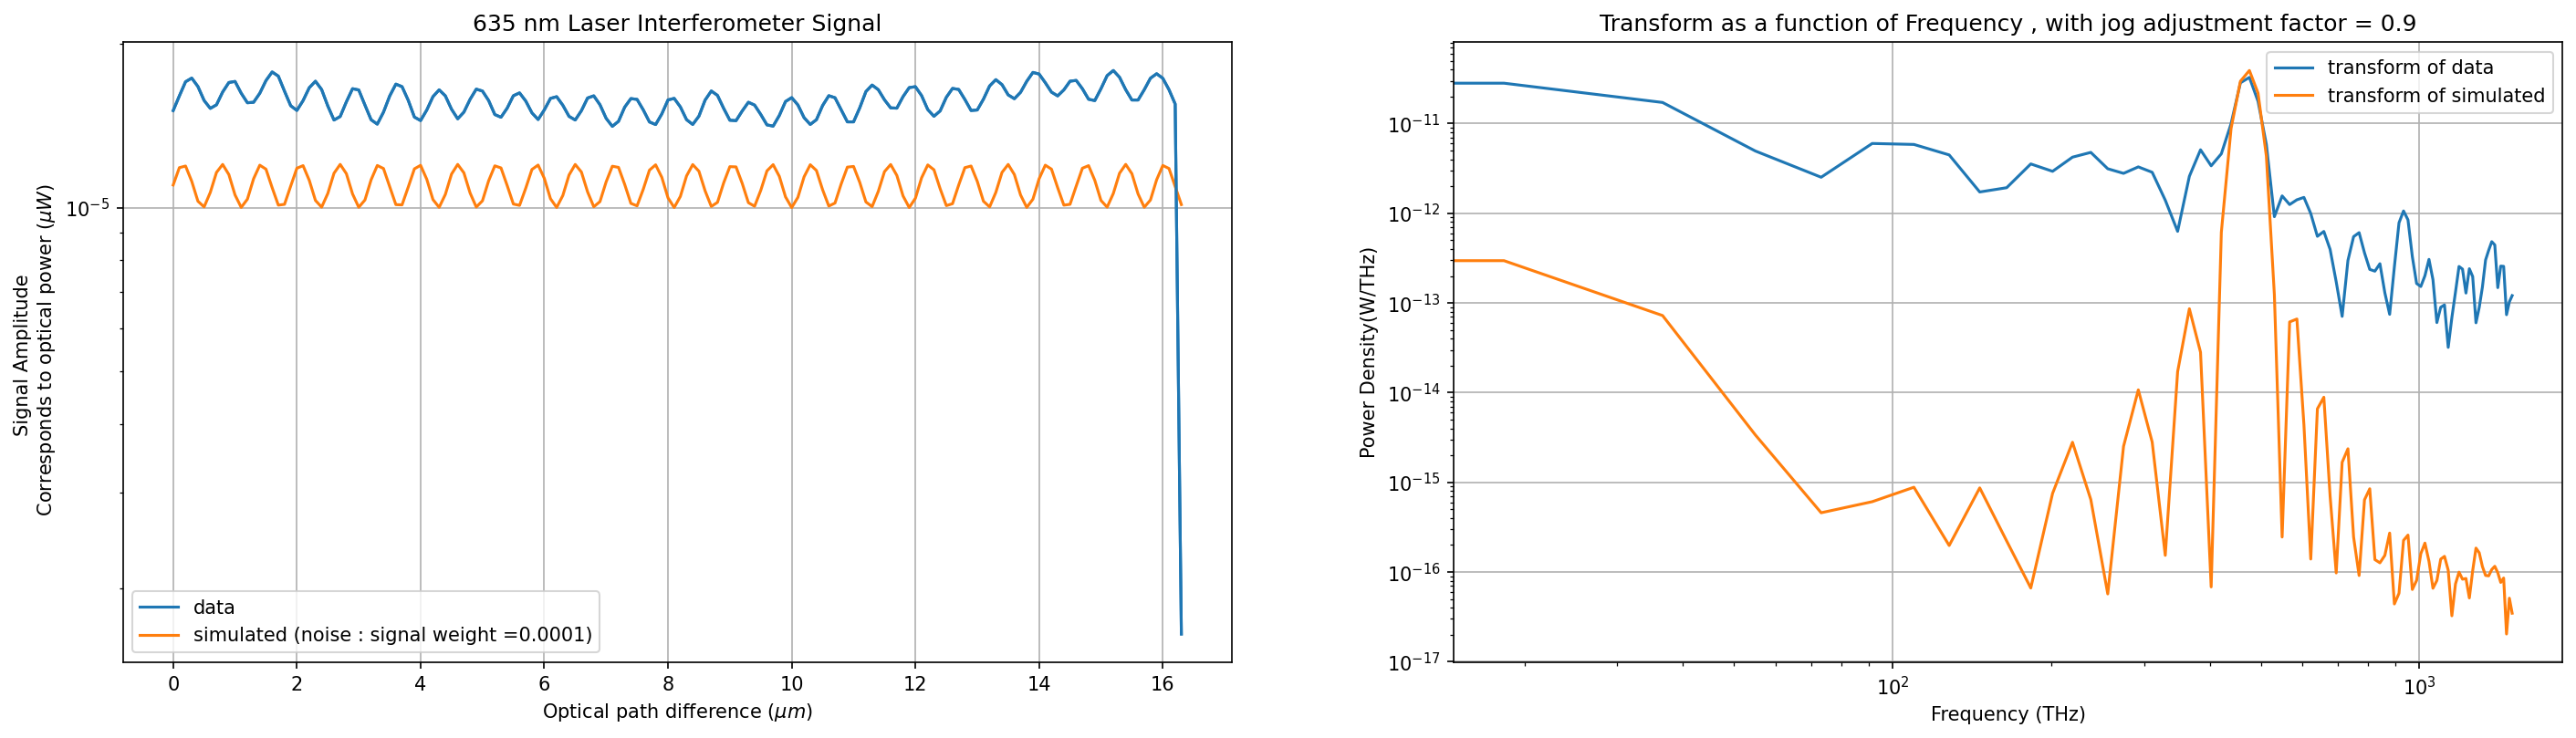

In [137]:
x_00, y_00 = generate_xy_plot(power_averaged_laser_nofilter_00)
frequency, spectrum = psd_frequency(y_00, 'parzen', fs)

#fill in the plot! 
fig = plt.figure(figsize=(23, 6), dpi=150)

plt.subplot(1, 2, 1)
plt.plot(x_00, y_00, label = 'data', color='C0')
plt.errorbar(x_00, y_00, power_error_laser_nofilter_00)
plt.plot(x_simulated, y_simulated_laser, label= "simulated (noise : signal weight ="+ str(round(noise_to_signal_ratio, 6)) +")", color='C1')

plt.subplot(1,2,2)
plt.semilogy(frequency, spectrum, label='transform of data ', color='C0')
plt.semilogy(frequency_simulated, spectrum_simulated, label='transform of simulated', color='C1')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
title = "635 nm Laser Interferometer Signal"
plt.title(title)
plt.legend()
plt.yscale('log')
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power ($\mu W$)")

#plot details for fourier transform plot 
plt.subplot(1, 2, 2)
if jog_adjustment:
  plt.title("Transform as a function of Frequency , with jog adjustment factor = " +  str(jog_adjustment_value))
else: 
  plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")

plt.show()

In [138]:
L = mm_to_micron * jog_dist* len(power_averaged_laser_nofilter_0)
dx = -1 * L/2
x_simulated, y_simulated, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=293)

## add peak at 635 nm to this blackbody background
lam = 635 * nm_to_micron 
k = 1/lam
scale_weight = 5e-7
add_weight = 1e-5
sigma = scale_weight*noise_to_signal_ratio
laser_scale = 4

y_simulated_laser = scale_weight*(y_simulated+ laser_scale*(np.sin(2*pi*k*x_simulated)/2.0 + 0.5))+ np.random.rand(len(x_simulated))*sigma + add_weight
frequency_simulated, spectrum_simulated = psd_frequency(y_simulated_laser, 'parzen')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


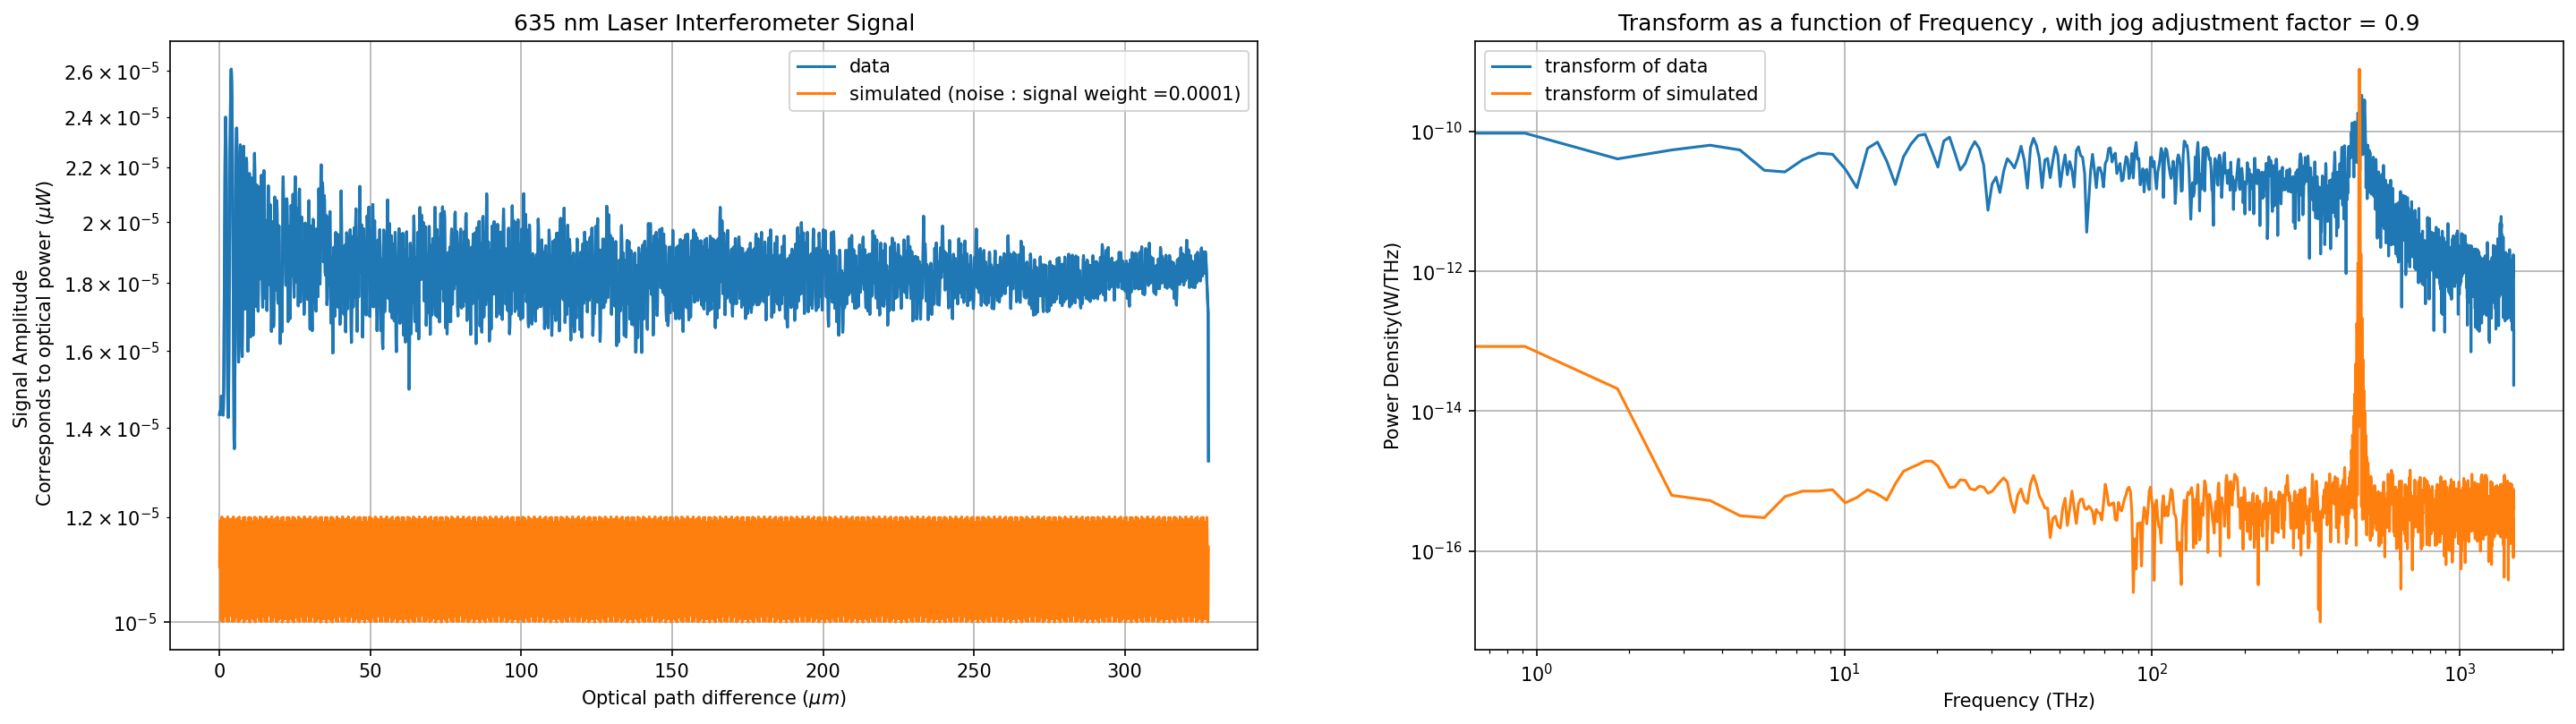

In [139]:
x_0, y_0 = generate_xy_plot(power_averaged_laser_nofilter_0)
frequency, spectrum = psd_frequency(y_0, 'parzen', fs)

#fill in the plot! 
fig = plt.figure(figsize=(23, 6), dpi=150)
  
plt.subplot(1, 2, 1)
plt.plot(x_0, y_0, label = 'data', color='C0')
plt.errorbar(x_0, y_0, power_error_laser_nofilter_0)
plt.plot(x_simulated, y_simulated_laser, label= "simulated (noise : signal weight ="+ str(round(noise_to_signal_ratio, 7)) +")", color='C1')

plt.subplot(1,2,2)
plt.semilogy(frequency, spectrum, label='transform of data ', color='C0')
plt.semilogy(frequency_simulated, spectrum_simulated, label='transform of simulated', color='C1')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
title = "635 nm Laser Interferometer Signal"
plt.title(title)
plt.legend()
plt.yscale('log')
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power ($\mu W$)")

#plot details for fourier transform plot 
plt.subplot(1, 2, 2)
if jog_adjustment:
  plt.title("Transform as a function of Frequency , with jog adjustment factor = " +  str(jog_adjustment_value))
else: 
  plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


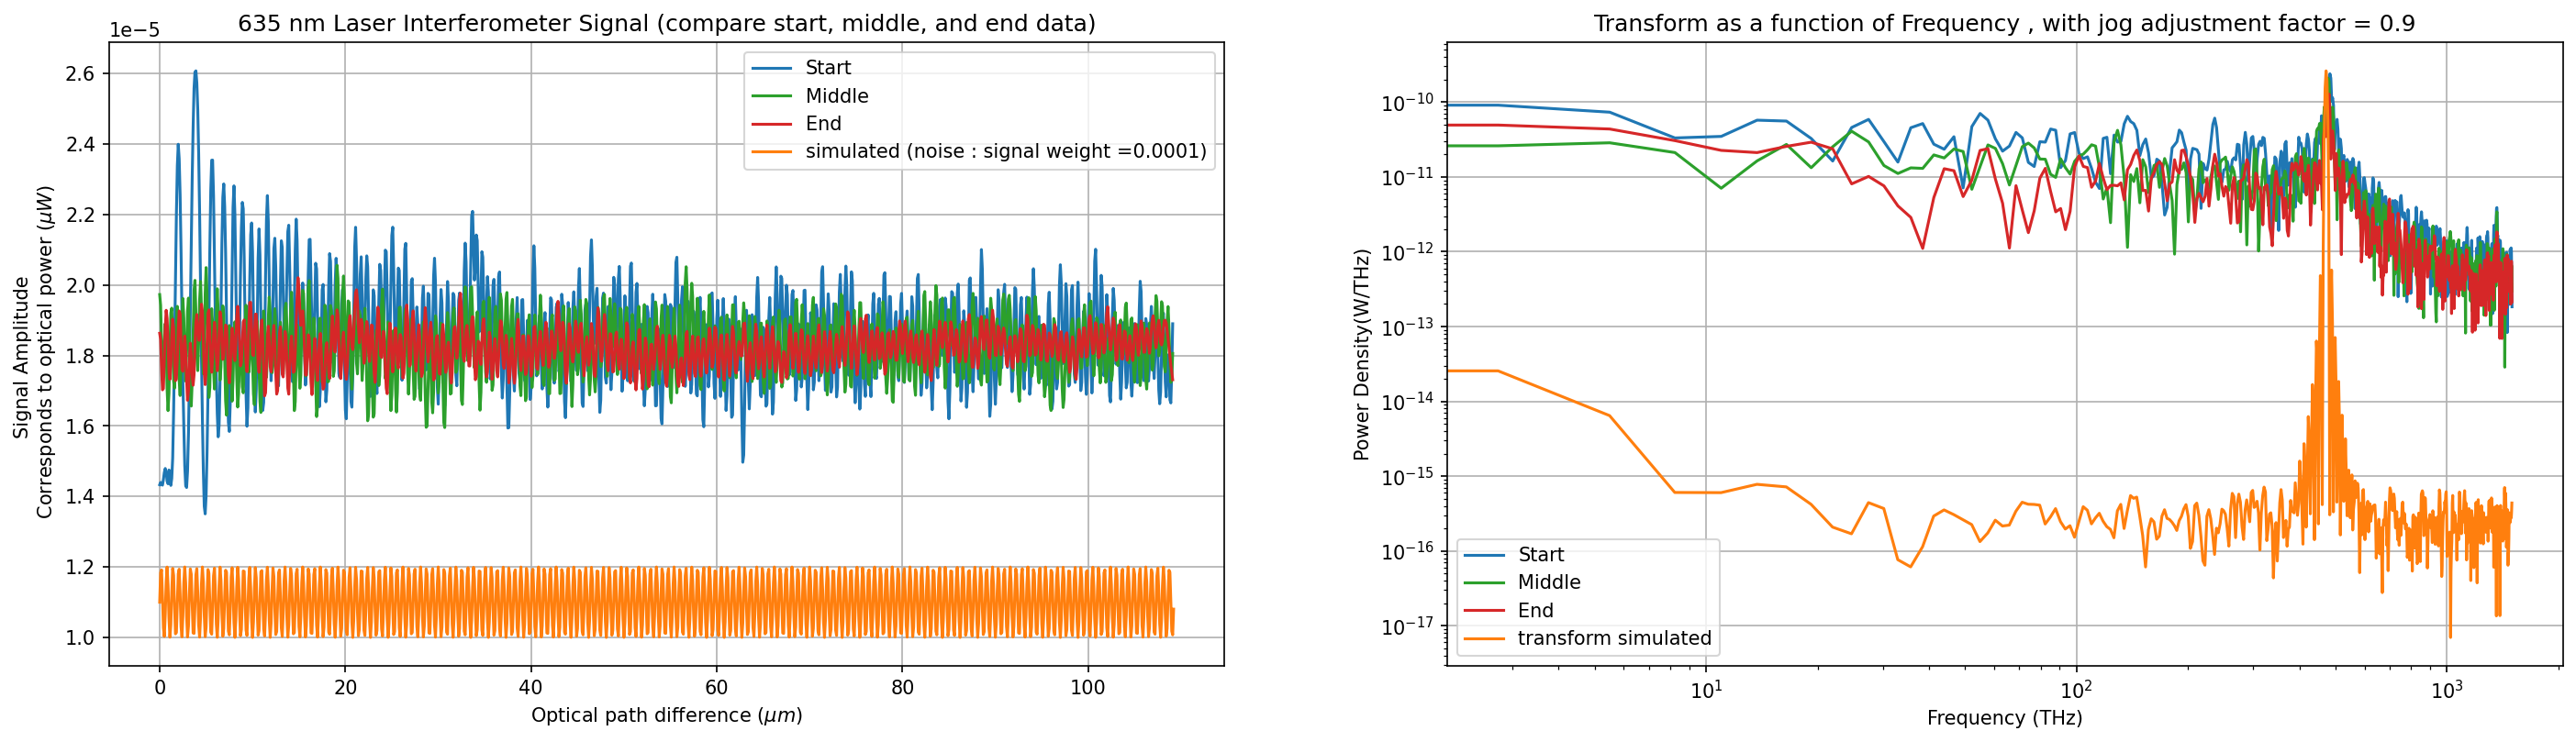

In [140]:
#### generate simulated data
L = mm_to_micron * jog_dist* len(power_averaged_laser_nofilter_0)/3
dx = -1*L/2
x_simulated, y_simulated, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=293)

## add peak at 635 nm to this blackbody background
lam = 635 * nm_to_micron 
k = 1/lam
scale_weight = 5e-7
add_weight = 1e-5
sigma = scale_weight * noise_to_signal_ratio #watt

y_simulated_laser = scale_weight*(y_simulated+ laser_scale*(np.sin(2*pi*k*x_simulated)/2.0 + 0.5))+ np.random.rand(len(x_simulated))*sigma + add_weight
frequency_simulated, spectrum_simulated = psd_frequency(y_simulated_laser, 'parzen')

## split the data into thirds
slice_size = int(len(power_averaged_laser_nofilter_0)/3) #size of slices 
x_short, y1 = generate_xy_plot(power_averaged_laser_nofilter_0[:slice_size], jog_dist=jog_dist)
x_short, y2 = generate_xy_plot(power_averaged_laser_nofilter_0[slice_size:2*slice_size], jog_dist=jog_dist)
x_short, y3 = generate_xy_plot(power_averaged_laser_nofilter_0[2*slice_size:3*slice_size], jog_dist=jog_dist)

fig = plt.figure(figsize=(23, 6), dpi=150)  
plt.subplot(1, 2, 1)
plt.plot(x_short, y1, label = 'Start', color='C0')
plt.plot(x_short, y2, label = 'Middle', color='C2')
plt.plot(x_short, y3, label = 'End', color='C3')
plt.plot(x_simulated, y_simulated_laser ,label= "simulated (noise : signal weight ="+ str(round(noise_to_signal_ratio, 7)) +")", color='C1')


plt.subplot(1,2,2)
frequency1, spectrum1 = psd_frequency(y1,  'parzen', fs)
frequency2, spectrum2 = psd_frequency(y2, 'parzen', fs)
frequency3, spectrum3 = psd_frequency(y3, 'parzen', fs)
plt.semilogy(frequency1, spectrum1, label='Start', color='C0')
plt.semilogy(frequency2, spectrum2, label='Middle', color='C2')
plt.semilogy(frequency3, spectrum3, label='End', color='C3')
plt.semilogy(frequency_simulated, spectrum_simulated, label='transform simulated', color='C1')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
title = "635 nm Laser Interferometer Signal (compare start, middle, and end data)"
plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power ($\mu W$)")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
if jog_adjustment:
  plt.title("Transform as a function of Frequency , with jog adjustment factor = " +  str(jog_adjustment_value))
else: 
  plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")

plt.show()

Plotting the PEW filter bandpass using the 3 trials of data taken

In [141]:
L = mm_to_micron * jog_dist* len(power_averaged_Si253_PEWFilter_9V)
dx = -1*L/2
x_simulated_PEW, y_simulated_PEW, weights_PEW, filter_val_PEW = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='PEW', dx=dx, L=L, dL=dL, Temp=get_temp(9))
x_simulated_nofilter, y_simulated_nofilter, weights_PEW = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL,  Temp=get_temp(9))

scale_weight = 5e-4
add_weight = 3e-5
sigma = scale_weight*noise_to_signal_ratio
y_simulated_PEW = scale_weight*y_simulated_PEW + np.random.rand(len(x_simulated_PEW))*sigma + add_weight
frequency_simulated_PEW, spectrum_simulated_PEW = psd_frequency(y_simulated_PEW, 'parzen')

y_simulated_nofilter = scale_weight*y_simulated_nofilter + np.random.rand(len(x_simulated_nofilter))*sigma + add_weight
frequency_simulated_nofilter, spectrum_simulated_nofilter = psd_frequency(y_simulated_nofilter, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


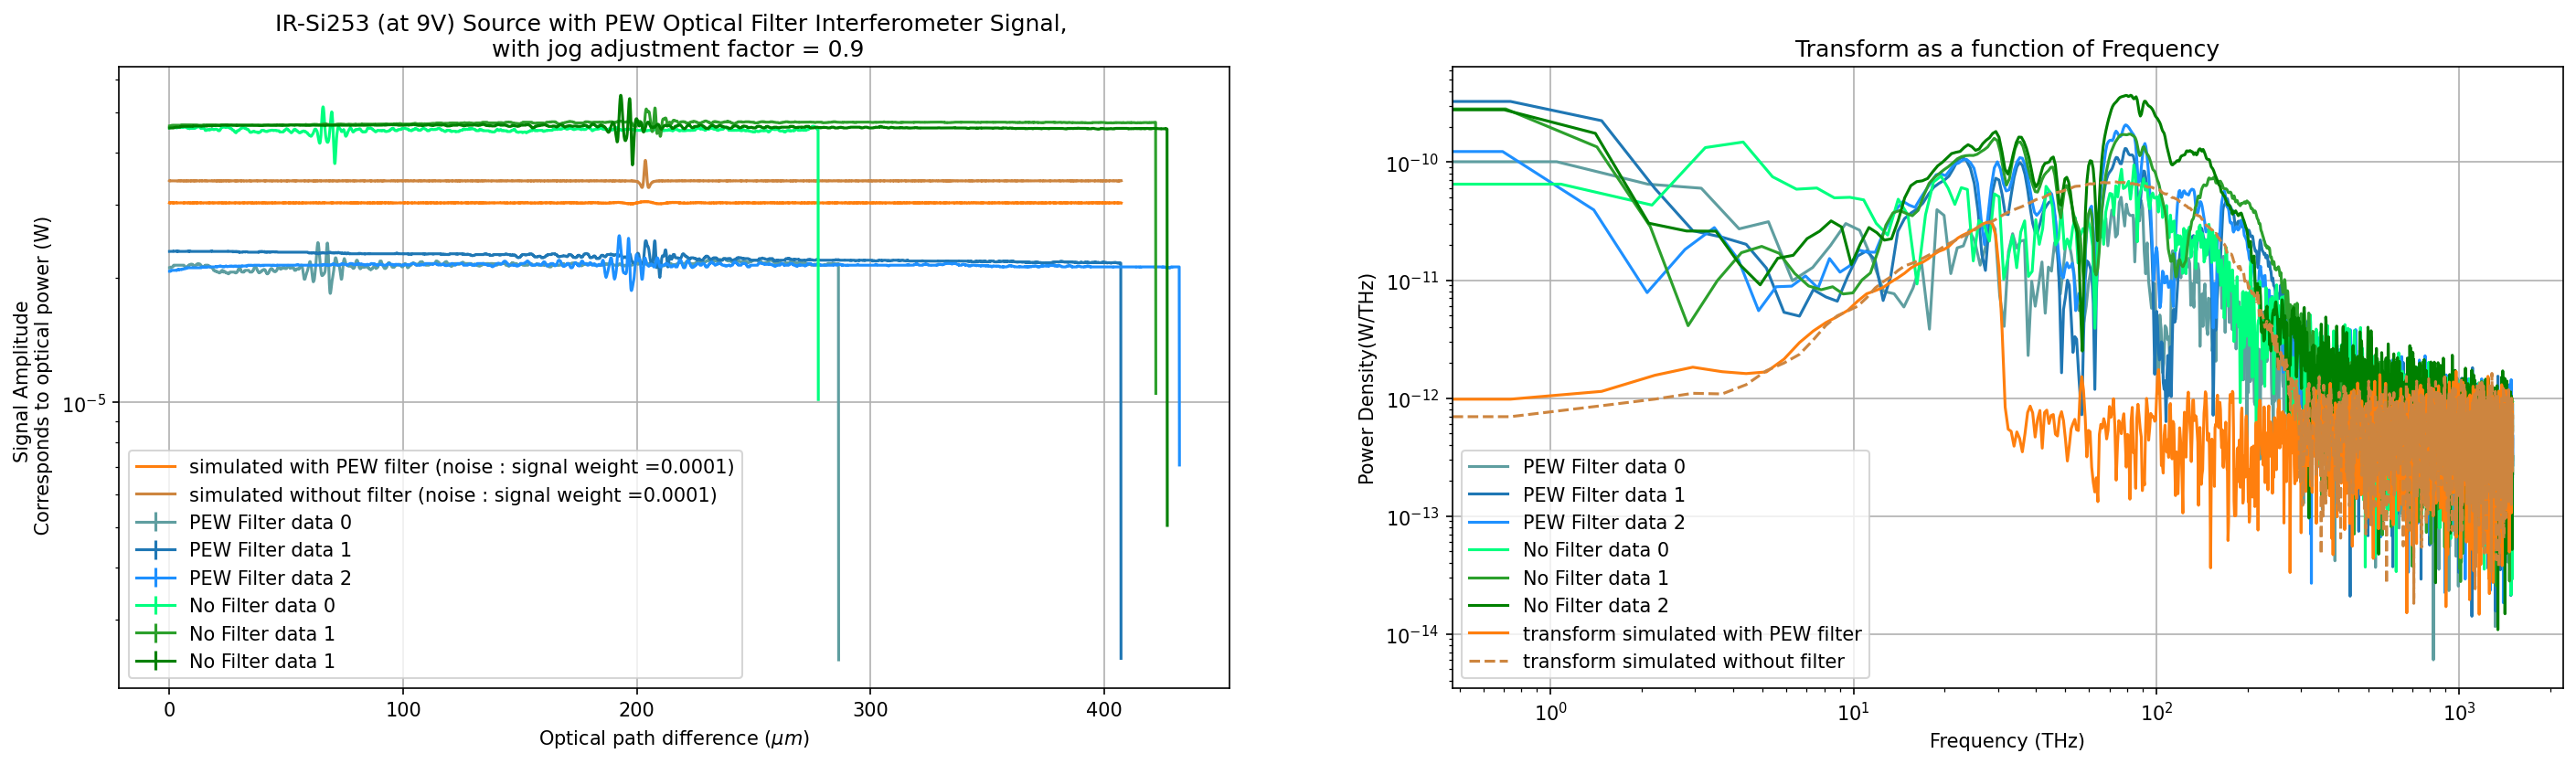

In [142]:
plot_nofilter = True
include_zer0th_trial = True
######generate x and y for plots ########
x_PEW_0, y_PEW_0 = generate_xy_plot(power_averaged_Si253_PEWFilter_9V_0)
x_PEW_1, y_PEW_1 = generate_xy_plot(power_averaged_Si253_PEWFilter_9V)
x_PEW_2, y_PEW_2 = generate_xy_plot(power_averaged_Si253_PEWFilter_9V_2)
x_nofilter_0, y_nofilter_0 = generate_xy_plot(power_averaged_Si253_noFilter_9V_0)
x_nofilter_1, y_nofilter_1 = generate_xy_plot(power_averaged_Si253_noFilter_9V)
x_nofilter_2, y_nofilter_2 = generate_xy_plot(power_averaged_Si253_noFilter_9V_2)

######## get transforms for y values ######
frequency_PEWfilter_0, spectrum_PEWfilter_0 = psd_frequency(y_PEW_0, 'parzen', fs)
frequency_PEWfilter_1, spectrum_PEWfilter_1 = psd_frequency(y_PEW_1, 'parzen', fs)
frequency_PEWfilter_2, spectrum_PEWfilter_2 = psd_frequency(y_PEW_2, 'parzen', fs)
frequency_nofilter_0, spectrum_nofilter_0 = psd_frequency(y_nofilter_0, 'parzen', fs)
frequency_nofilter_1, spectrum_nofilter_1 = psd_frequency(y_nofilter_1, 'parzen', fs)
frequency_nofilter_2, spectrum_nofilter_2 = psd_frequency(y_nofilter_2, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
if include_zer0th_trial:
  plt.errorbar(x_PEW_0, y_PEW_0, power_error_Si253_PEWFilter_9V_0,  label = 'PEW Filter data 0', color='cadetblue')
plt.errorbar(x_PEW_1, y_PEW_1, power_error_Si253_PEWFilter_9V,  label = 'PEW Filter data 1', color='C0')
plt.errorbar(x_PEW_2, y_PEW_2, power_error_Si253_PEWFilter_9V_2,  label = 'PEW Filter data 2', color='dodgerblue')
plt.errorbar(x_nofilter_0, y_nofilter_0, power_error_Si253_noFilter_9V_0, label = 'No Filter data 0', color='springgreen')
plt.errorbar(x_nofilter_1, y_nofilter_1, power_error_Si253_noFilter_9V, label = 'No Filter data 1', color='C2')
plt.errorbar(x_nofilter_2, y_nofilter_2, power_error_Si253_noFilter_9V_2, label = 'No Filter data 1', color='green')
plt.plot(x_simulated_PEW, y_simulated_PEW ,label= "simulated with PEW filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='C1')
if plot_nofilter:
  plt.plot(x_simulated_nofilter, y_simulated_nofilter,label= "simulated without filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='peru')

########### transform plot ##############
plt.subplot(1,2,2)
if include_zer0th_trial:
  plt.semilogy(frequency_PEWfilter_0, spectrum_PEWfilter_0, label='PEW Filter data 0', color='cadetblue')
plt.semilogy(frequency_PEWfilter_1, spectrum_PEWfilter_1, label='PEW Filter data 1', color='C0')
plt.semilogy(frequency_PEWfilter_2, spectrum_PEWfilter_2, label='PEW Filter data 2', color='dodgerblue')
plt.semilogy(frequency_nofilter_0, spectrum_nofilter_0, label='No Filter data 0', color='springgreen')
plt.semilogy(frequency_nofilter_1, spectrum_nofilter_1, label='No Filter data 1', color='C2')
plt.semilogy(frequency_nofilter_2, spectrum_nofilter_2, label='No Filter data 2', color='green')
plt.semilogy(frequency_simulated_PEW, spectrum_simulated_PEW, label='transform simulated with PEW filter', color='C1')
if plot_nofilter:
  plt.semilogy(frequency_simulated_nofilter, spectrum_simulated_nofilter, '--', label='transform simulated without filter', color='peru')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
if jog_adjustment:
  title = "IR-Si253 (at 9V) Source with PEW Optical Filter Interferometer Signal, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 (at 9V) Source with PEW Optical Filter Interferometer Signal"
plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')

plt.show()

Text(0, 0.5, 'Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra')

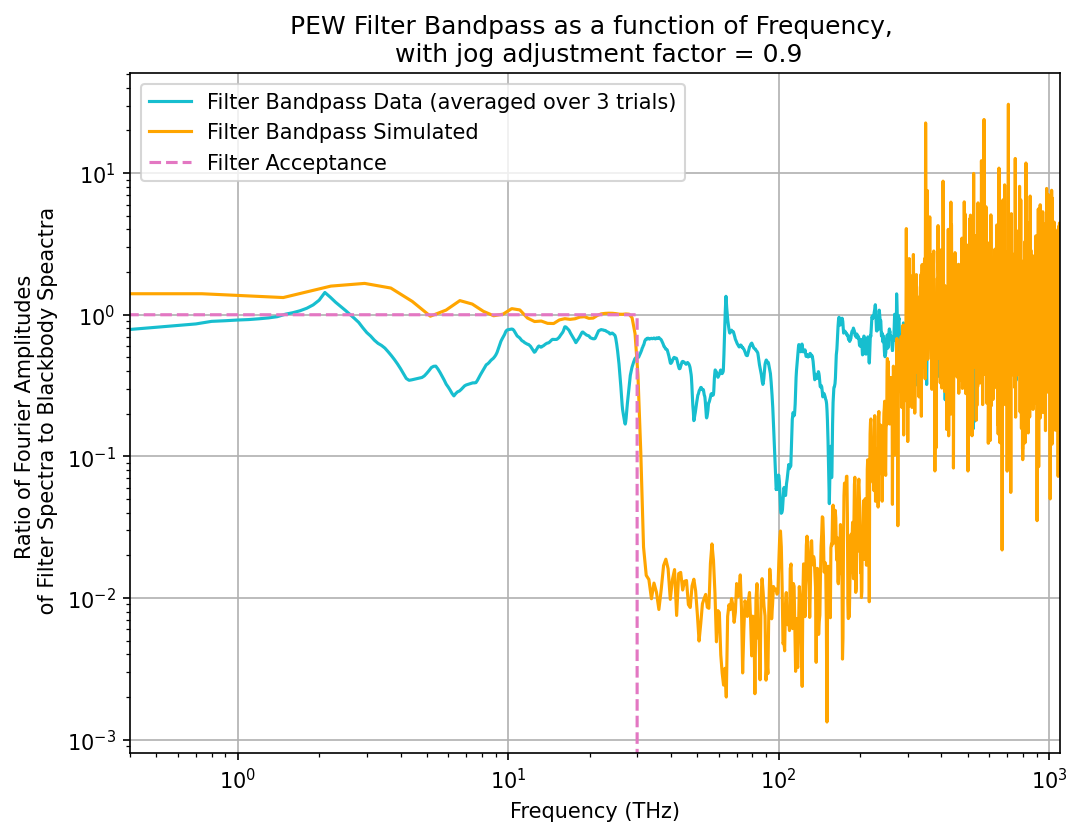

In [143]:
#########plot of filter transmittance#############
#### interpolate the transform! to make sure we can divide out the different arrays
interpolate_PEW_0 = interp1d(frequency_PEWfilter_0, spectrum_PEWfilter_0, fill_value='extrapolate')
interpolate_PEW_1 = interp1d(frequency_PEWfilter_1, spectrum_PEWfilter_1, fill_value='extrapolate')
interpolate_PEW_2 = interp1d(frequency_PEWfilter_2, spectrum_PEWfilter_2, fill_value='extrapolate')
interpolate_nofilter_0 = interp1d(frequency_nofilter_0, spectrum_nofilter_0, fill_value='extrapolate')
interpolate_nofilter_1 = interp1d(frequency_nofilter_1, spectrum_nofilter_1, fill_value='extrapolate')
interpolate_nofilter_2 = interp1d(frequency_nofilter_2, spectrum_nofilter_2, fill_value='extrapolate')

frequency_array = np.arange(0.1,1100, 0.1)

average_PEW = [mean(i) for i in zip(interpolate_PEW_0(frequency_array),interpolate_PEW_1(frequency_array), interpolate_PEW_2(frequency_array))]
average_nofilter = [mean(i) for i in zip(interpolate_nofilter_0(frequency_array),interpolate_nofilter_1(frequency_array), interpolate_nofilter_2(frequency_array))]
ratio_transform =  np.array(average_PEW)/np.array(average_nofilter)

fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data (averaged over 3 trials)", color='C9')
plt.plot(frequency_simulated_nofilter, spectrum_simulated_PEW/spectrum_simulated_nofilter, label = "Filter Bandpass Simulated", color='orange')
plt.semilogy(frequencies, filter_val_PEW, '--', label = 'Filter Acceptance', color='C6')

if jog_adjustment:
  title = "PEW Filter Bandpass as a function of Frequency, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "PEW Filter Bandpass as a function of Frequency"

plt.title(title)
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlim(4e-1, 1100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")

Plotting the SiW filter bandpass using the 2 trials of data taken

In [144]:
L = mm_to_micron * jog_dist* len(power_averaged_Si253_SiWFilter_9V)
dx = -1*L/2
x_simulated_SiW, y_simulated_SiW, weights_SiW, filter_val_SiW = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='SiW', dx=dx, L=L, dL=dL, Temp=get_temp(9))
x_simulated_nofilter, y_simulated_nofilter, weights_PEW = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(9))

scale_weight = 5e-4
add_weight = 3e-5
sigma = scale_weight*noise_to_signal_ratio
y_simulated_SiW = scale_weight*y_simulated_SiW + np.random.rand(len(x_simulated_SiW))*sigma + add_weight
frequency_simulated_SiW, spectrum_simulated_SiW = psd_frequency(y_simulated_SiW, 'parzen')

y_simulated_nofilter = scale_weight*y_simulated_nofilter + np.random.rand(len(x_simulated_nofilter))*sigma + add_weight
frequency_simulated_nofilter, spectrum_simulated_nofilter = psd_frequency(y_simulated_nofilter, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


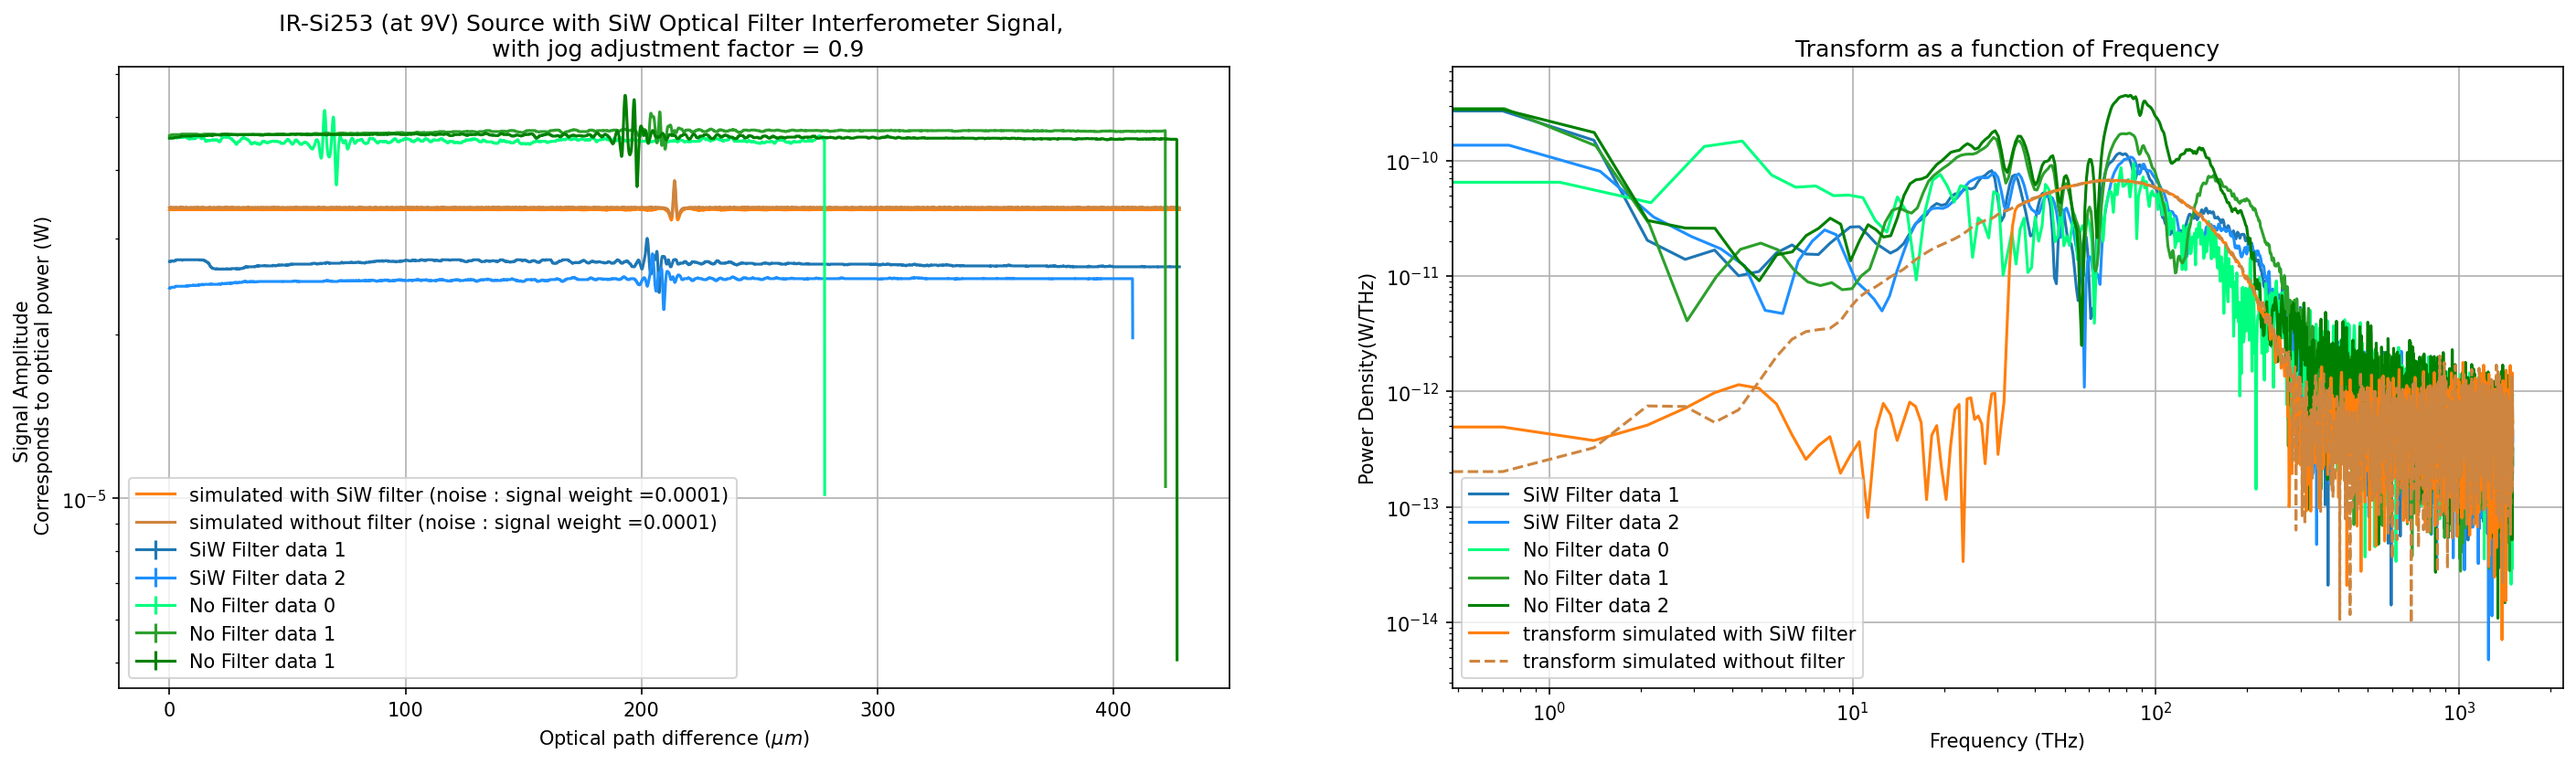

In [145]:
plot_nofilter = True
######generate x and y for plots ########
x_SiW_1, y_SiW_1 = generate_xy_plot(power_averaged_Si253_SiWFilter_9V)
x_SiW_2, y_SiW_2 = generate_xy_plot(power_averaged_Si253_SiWFilter_9V_2)
x_nofilter_0, y_nofilter_0 = generate_xy_plot(power_averaged_Si253_noFilter_9V_0)
x_nofilter_1, y_nofilter_1 = generate_xy_plot(power_averaged_Si253_noFilter_9V)
x_nofilter_2, y_nofilter_2 = generate_xy_plot(power_averaged_Si253_noFilter_9V_2)

######## get transforms for y values ######
frequency_SiWfilter_1, spectrum_SiWfilter_1 = psd_frequency(y_SiW_1, 'parzen', fs)
frequency_SiWfilter_2, spectrum_SiWfilter_2 = psd_frequency(y_SiW_2, 'parzen', fs)
frequency_nofilter_0, spectrum_nofilter_0 = psd_frequency(y_nofilter_0, 'parzen', fs)
frequency_nofilter_1, spectrum_nofilter_1 = psd_frequency(y_nofilter_1, 'parzen', fs)
frequency_nofilter_2, spectrum_nofilter_2 = psd_frequency(y_nofilter_2, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
plt.errorbar(x_SiW_1, y_SiW_1, power_error_Si253_SiWFilter_9V,  label = 'SiW Filter data 1', color='C0')
plt.errorbar(x_SiW_2, y_SiW_2, power_error_Si253_SiWFilter_9V_2,  label = 'SiW Filter data 2', color='dodgerblue')
plt.errorbar(x_nofilter_0, y_nofilter_0, power_error_Si253_noFilter_9V_0, label = 'No Filter data 0', color='springgreen')
plt.errorbar(x_nofilter_1, y_nofilter_1, power_error_Si253_noFilter_9V, label = 'No Filter data 1', color='C2')
plt.errorbar(x_nofilter_2, y_nofilter_2, power_error_Si253_noFilter_9V_2, label = 'No Filter data 1', color='green')
plt.plot(x_simulated_SiW, y_simulated_SiW ,label= "simulated with SiW filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='C1')
if plot_nofilter:
  plt.plot(x_simulated_nofilter, y_simulated_nofilter,label= "simulated without filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='peru')

########### transform plot ##############
plt.subplot(1,2,2)
plt.semilogy(frequency_SiWfilter_1, spectrum_SiWfilter_1, label='SiW Filter data 1', color='C0')
plt.semilogy(frequency_SiWfilter_2, spectrum_SiWfilter_2, label='SiW Filter data 2', color='dodgerblue')
plt.semilogy(frequency_nofilter_0, spectrum_nofilter_0, label='No Filter data 0', color='springgreen')
plt.semilogy(frequency_nofilter_1, spectrum_nofilter_1, label='No Filter data 1', color='C2')
plt.semilogy(frequency_nofilter_2, spectrum_nofilter_2, label='No Filter data 2', color='green')
plt.semilogy(frequency_simulated_SiW, spectrum_simulated_SiW, label='transform simulated with SiW filter', color='C1')
if plot_nofilter:
  plt.semilogy(frequency_simulated_nofilter, spectrum_simulated_nofilter, '--', label='transform simulated without filter', color='peru')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
if jog_adjustment:
  title = "IR-Si253 (at 9V) Source with SiW Optical Filter Interferometer Signal, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 (at 9V) Source with SiW Optical Filter Interferometer Signal"
plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')

plt.show()

Text(0, 0.5, 'Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra')

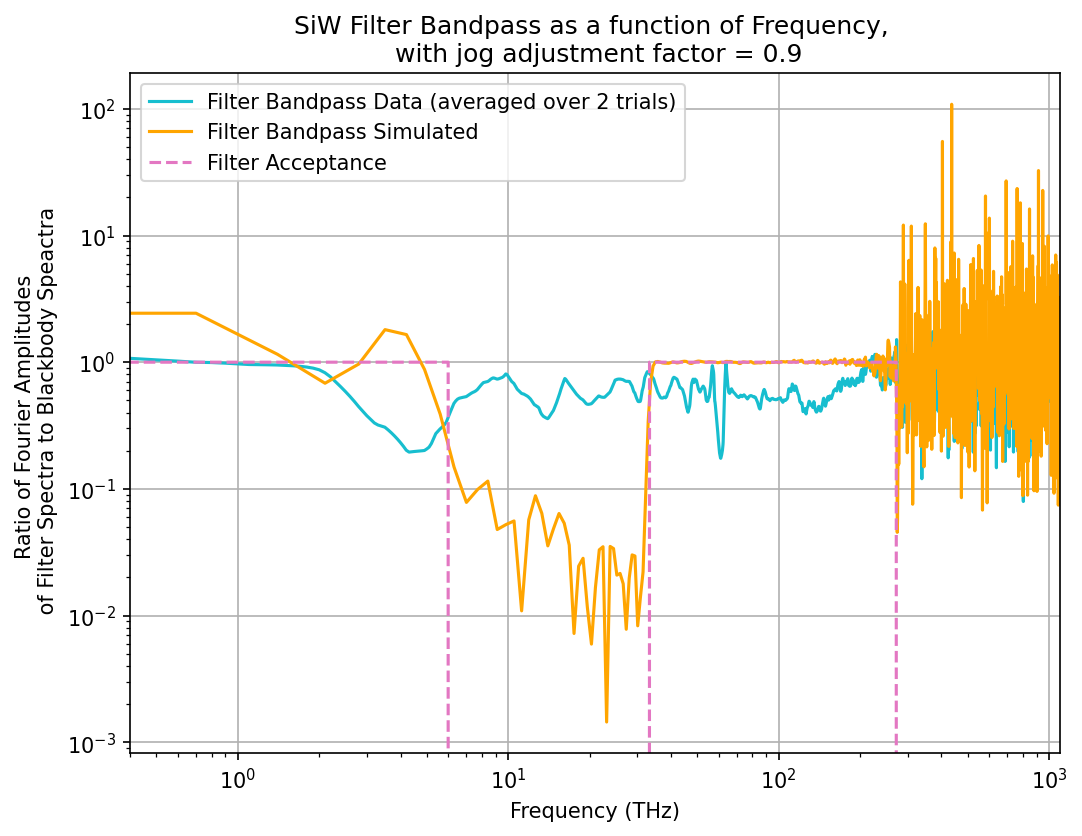

In [146]:
#########plot of filter transmittance#############
#### interpolate the transform! to make sure we can divide out the different arrays
interpolate_SiW_1 = interp1d(frequency_SiWfilter_1, spectrum_SiWfilter_1, fill_value='extrapolate')
interpolate_SiW_2 = interp1d(frequency_SiWfilter_2, spectrum_SiWfilter_2, fill_value='extrapolate')
interpolate_nofilter_0 = interp1d(frequency_nofilter_0, spectrum_nofilter_0, fill_value='extrapolate')
interpolate_nofilter_1 = interp1d(frequency_nofilter_1, spectrum_nofilter_1, fill_value='extrapolate')
interpolate_nofilter_2 = interp1d(frequency_nofilter_2, spectrum_nofilter_2, fill_value='extrapolate')

frequency_array = np.arange(0.1,1100, 0.1)

average_SiW = [mean(i) for i in zip(interpolate_SiW_1(frequency_array), interpolate_SiW_2(frequency_array))]
average_nofilter = [mean(i) for i in zip(interpolate_nofilter_0(frequency_array),interpolate_nofilter_1(frequency_array), interpolate_nofilter_2(frequency_array))]
ratio_transform =  np.array(average_SiW)/np.array(average_nofilter)


fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data (averaged over 2 trials)", color='C9')
plt.plot(frequency_simulated_nofilter, spectrum_simulated_SiW/spectrum_simulated_nofilter, label = "Filter Bandpass Simulated", color='orange')
plt.semilogy(frequencies, filter_val_SiW, '--', label = 'Filter Acceptance', color='C6')
if jog_adjustment:
  title = "SiW Filter Bandpass as a function of Frequency, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "SiW Filter Bandpass as a function of Frequency"
plt.title(title)
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlim(4e-1, 1100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")

######## Plastic bag as an optical Filter ########

In [147]:
L = mm_to_micron * jog_dist* len(power_averaged_Si253_bagFilter_9V)
dx = -1*L/2
x_simulated_bag, y_simulated_bag_unscaled, weights_bag = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(9))

In [148]:
scale_weight = 5e-3
add_weight = 3e-5
sigma = scale_weight*noise_to_signal_ratio
y_simulated_bag= scale_weight*y_simulated_bag_unscaled + np.random.rand(len(x_simulated_bag))*sigma + add_weight
frequency_simulated_bag, spectrum_simulated_bag = psd_frequency(y_simulated_bag, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


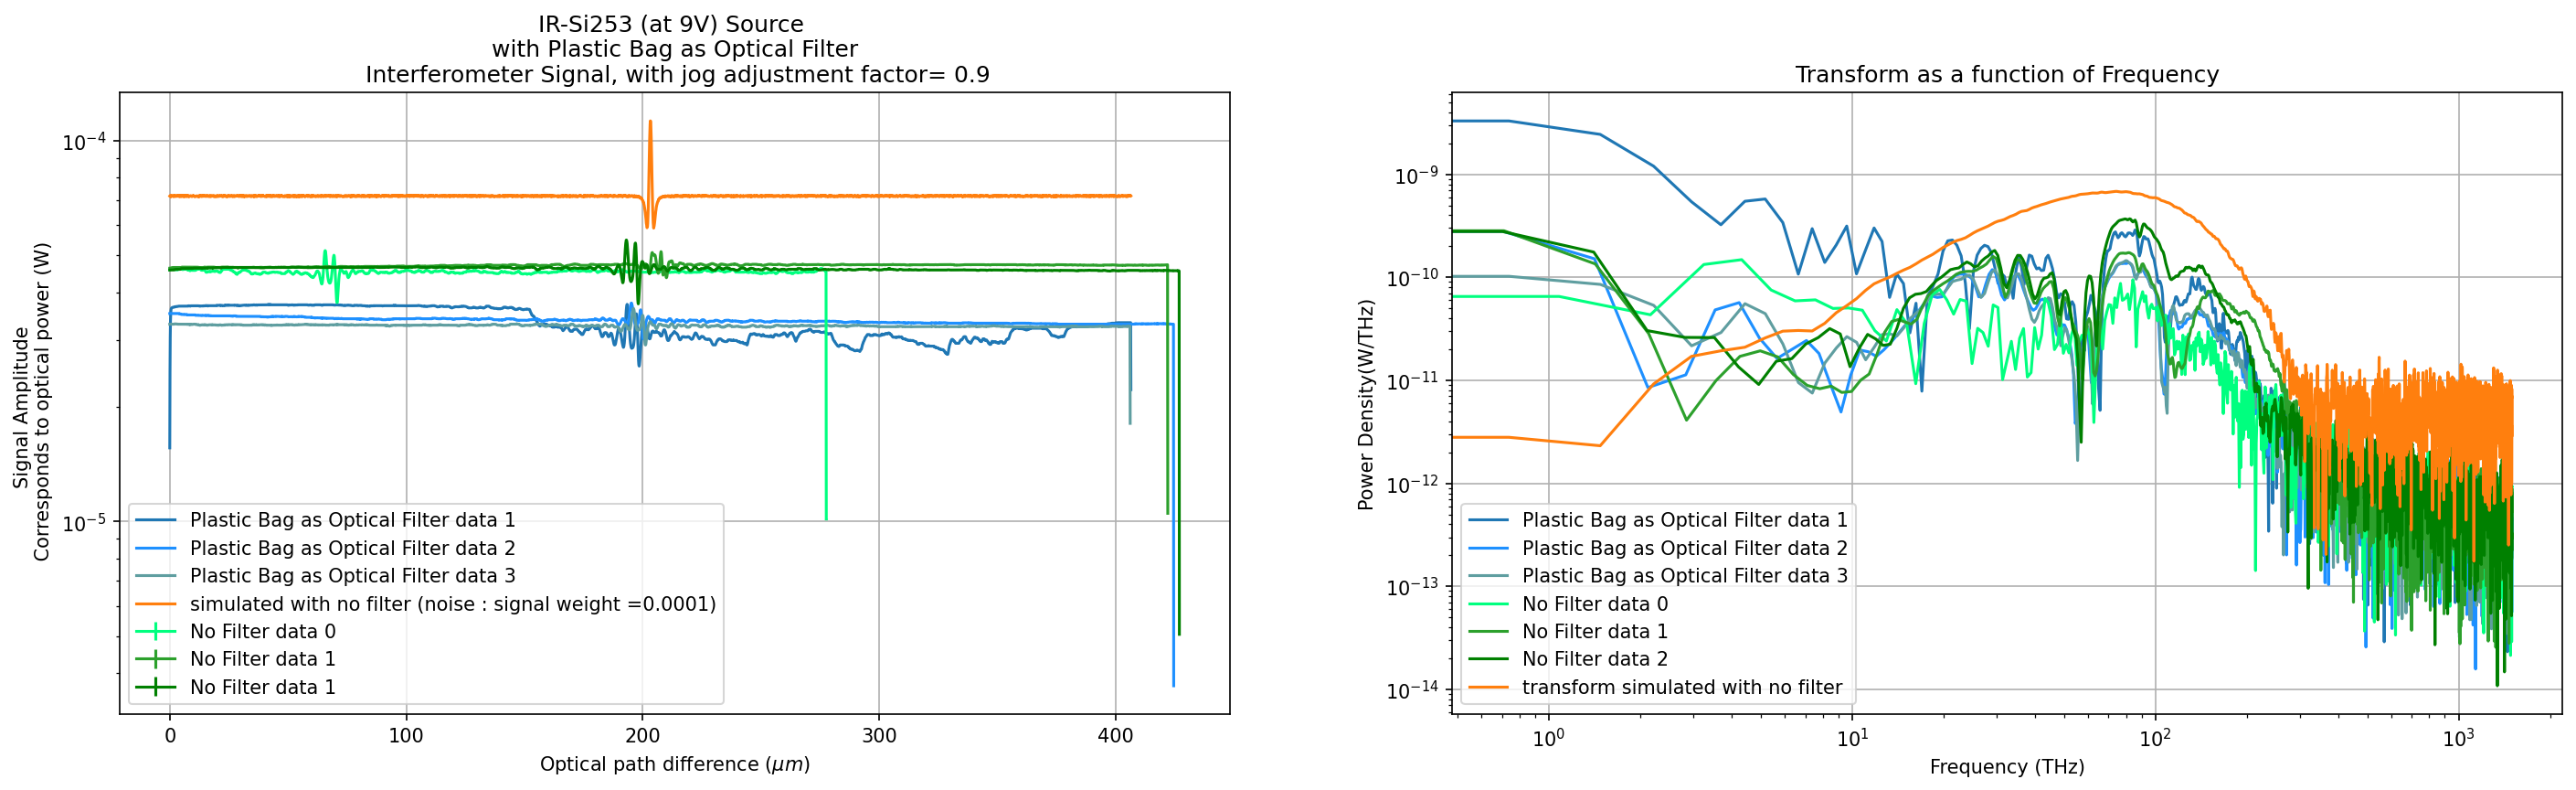

In [149]:
######generate x and y for plots ########
x_bag_1, y_bag_1 = generate_xy_plot(power_averaged_Si253_bagFilter_9V)
x_bag_2, y_bag_2 = generate_xy_plot(power_averaged_Si253_bagFilter_9V_2)
x_bag_3, y_bag_3 = generate_xy_plot(power_averaged_Si253_bagFilter_9V_3)
x_nofilter_0, y_nofilter_0 = generate_xy_plot(power_averaged_Si253_noFilter_9V_0)
x_nofilter_1, y_nofilter_1 = generate_xy_plot(power_averaged_Si253_noFilter_9V)
x_nofilter_2, y_nofilter_2 = generate_xy_plot(power_averaged_Si253_noFilter_9V_2)

######## get transforms for y values ######
frequency_bagfilter_1, spectrum_bagfilter_1 = psd_frequency(y_bag_1, 'parzen', fs)
frequency_bagfilter_2, spectrum_bagfilter_2 = psd_frequency(y_bag_2, 'parzen', fs)
frequency_bagfilter_3, spectrum_bagfilter_3 = psd_frequency(y_bag_3, 'parzen', fs)
frequency_nofilter_0, spectrum_nofilter_0 = psd_frequency(y_nofilter_0, 'parzen', fs)
frequency_nofilter_1, spectrum_nofilter_1 = psd_frequency(y_nofilter_1, 'parzen', fs)
frequency_nofilter_2, spectrum_nofilter_2 = psd_frequency(y_nofilter_2, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
plt.plot(x_bag_1, y_bag_1, label = 'Plastic Bag as Optical Filter data 1', color='C0')
plt.plot(x_bag_2, y_bag_2,  label = 'Plastic Bag as Optical Filter data 2', color='dodgerblue')
plt.plot(x_bag_3, y_bag_3, label = 'Plastic Bag as Optical Filter data 3', color='cadetblue')
plt.errorbar(x_nofilter_0, y_nofilter_0, power_error_Si253_noFilter_9V_0, label = 'No Filter data 0', color='springgreen')
plt.errorbar(x_nofilter_1, y_nofilter_1, power_error_Si253_noFilter_9V, label = 'No Filter data 1', color='C2')
plt.errorbar(x_nofilter_2, y_nofilter_2, power_error_Si253_noFilter_9V_2, label = 'No Filter data 1', color='green')
plt.plot(x_simulated_bag, y_simulated_bag ,label= "simulated with no filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='C1')


########### transform plot ##############
plt.subplot(1,2,2)
plt.semilogy(frequency_bagfilter_1, spectrum_bagfilter_1, label='Plastic Bag as Optical Filter data 1', color='C0')
plt.semilogy(frequency_bagfilter_2, spectrum_bagfilter_2, label='Plastic Bag as Optical Filter data 2', color='dodgerblue')
plt.semilogy(frequency_bagfilter_3, spectrum_bagfilter_3, label='Plastic Bag as Optical Filter data 3', color='cadetblue')
plt.semilogy(frequency_nofilter_0, spectrum_nofilter_0, label='No Filter data 0', color='springgreen')
plt.semilogy(frequency_nofilter_1, spectrum_nofilter_1, label='No Filter data 1', color='C2')
plt.semilogy(frequency_nofilter_2, spectrum_nofilter_2, label='No Filter data 2', color='green')
plt.semilogy(frequency_simulated_bag, spectrum_simulated_bag, label='transform simulated with no filter', color='C1')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)

if jog_adjustment:
  title = "IR-Si253 (at 9V) Source \n with Plastic Bag as Optical Filter \n Interferometer Signal, with jog adjustment factor= " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 (at 9V) Source \n with Plastic Bag as Optical Filter \n Interferometer Signal"

plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')

plt.show()

Text(0, 0.5, 'Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra')

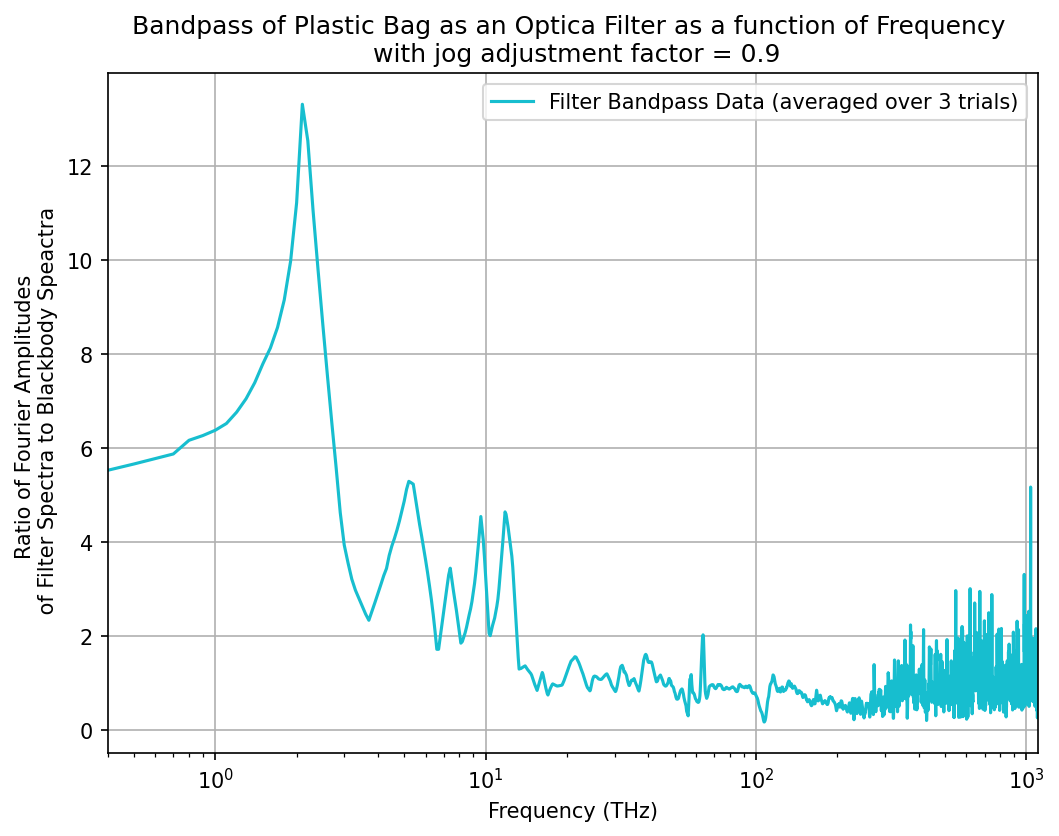

In [150]:
#########plot of filter transmittance#############
#### interpolate the transform! to make sure we can divide out the different arrays
interpolate_bag_1 = interp1d(frequency_bagfilter_1, spectrum_bagfilter_1, fill_value='extrapolate')
interpolate_bag_2 = interp1d(frequency_bagfilter_2, spectrum_bagfilter_2, fill_value='extrapolate')
interpolate_bag_3 = interp1d(frequency_bagfilter_3, spectrum_bagfilter_3, fill_value='extrapolate')

frequency_array = np.arange(0.1,1100, 0.1)

average_bag= [mean(i) for i in zip(interpolate_bag_1(frequency_array), interpolate_bag_2(frequency_array), interpolate_bag_3(frequency_array))]
ratio_transform =  np.array(average_bag)/np.array(average_nofilter)

fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data (averaged over 3 trials)", color='C9')

if jog_adjustment:
  title = "Bandpass of Plastic Bag as an Optica Filter as a function of Frequency \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "Bandpass of Plastic Bag as an Optica Filter as a function of Frequency"

plt.title(title)
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlim(4e-1, 1100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")

########## plastic bag filled with isopropanol as optical filter #########

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


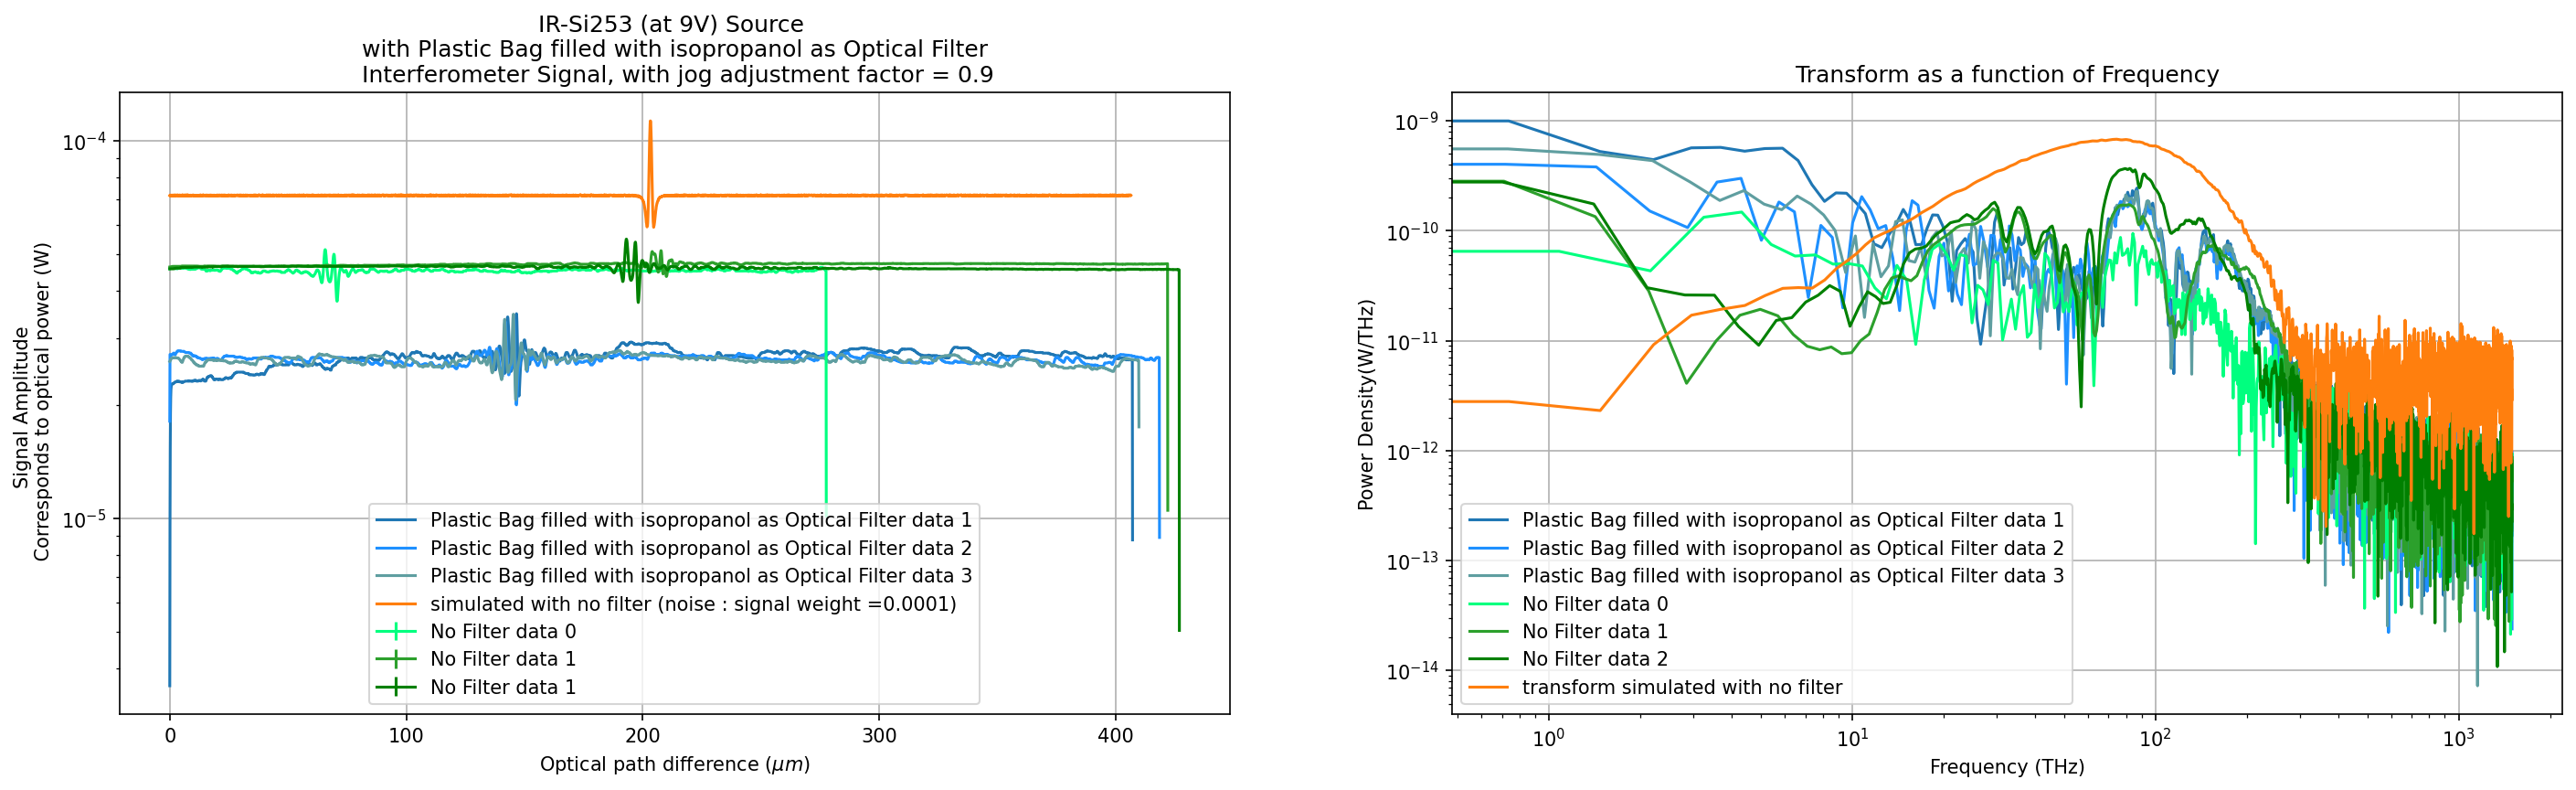

In [151]:
######generate x and y for plots ########
x_isopropanol_bag_1, y_isopropanol_bag_1 = generate_xy_plot(power_averaged_Si253_isopropanol_bagFilter_9V)
x_isopropanol_bag_2, y_isopropanol_bag_2 = generate_xy_plot(power_averaged_Si253_isopropanol_bagFilter_9V_2)
x_isopropanol_bag_3, y_isopropanol_bag_3 = generate_xy_plot(power_averaged_Si253_isopropanol_bagFilter_9V_3)
x_nofilter_0, y_nofilter_0 = generate_xy_plot(power_averaged_Si253_noFilter_9V_0)
x_nofilter_1, y_nofilter_1 = generate_xy_plot(power_averaged_Si253_noFilter_9V)
x_nofilter_2, y_nofilter_2 = generate_xy_plot(power_averaged_Si253_noFilter_9V_2)

######## get transforms for y values ######
frequency_isopropanol_bagfilter_1, spectrum_isopropanol_bagfilter_1 = psd_frequency(y_isopropanol_bag_1, 'parzen', fs)
frequency_isopropanol_bagfilter_2, spectrum_isopropanol_bagfilter_2 = psd_frequency(y_isopropanol_bag_2, 'parzen', fs)
frequency_isopropanol_bagfilter_3, spectrum_isopropanol_bagfilter_3 = psd_frequency(y_isopropanol_bag_3, 'parzen', fs)
frequency_nofilter_0, spectrum_nofilter_0 = psd_frequency(y_nofilter_0, 'parzen', fs)
frequency_nofilter_1, spectrum_nofilter_1 = psd_frequency(y_nofilter_1, 'parzen', fs)
frequency_nofilter_2, spectrum_nofilter_2 = psd_frequency(y_nofilter_2, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
plt.plot(x_isopropanol_bag_1, y_isopropanol_bag_1, label = 'Plastic Bag filled with isopropanol as Optical Filter data 1', color='C0')
plt.plot(x_isopropanol_bag_2, y_isopropanol_bag_2,  label = 'Plastic Bag filled with isopropanol as Optical Filter data 2', color='dodgerblue')
plt.plot(x_isopropanol_bag_3, y_isopropanol_bag_3, label = 'Plastic Bag filled with isopropanol as Optical Filter data 3', color='cadetblue')
plt.errorbar(x_nofilter_0, y_nofilter_0, power_error_Si253_noFilter_9V_0, label = 'No Filter data 0', color='springgreen')
plt.errorbar(x_nofilter_1, y_nofilter_1, power_error_Si253_noFilter_9V, label = 'No Filter data 1', color='C2')
plt.errorbar(x_nofilter_2, y_nofilter_2, power_error_Si253_noFilter_9V_2, label = 'No Filter data 1', color='green')
plt.plot(x_simulated_bag, y_simulated_bag ,label= "simulated with no filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='C1')


########### transform plot ##############
plt.subplot(1,2,2)
plt.semilogy(frequency_isopropanol_bagfilter_1, spectrum_isopropanol_bagfilter_1, label='Plastic Bag filled with isopropanol as Optical Filter data 1', color='C0')
plt.semilogy(frequency_isopropanol_bagfilter_2, spectrum_isopropanol_bagfilter_2, label='Plastic Bag filled with isopropanol as Optical Filter data 2', color='dodgerblue')
plt.semilogy(frequency_isopropanol_bagfilter_3, spectrum_isopropanol_bagfilter_3, label='Plastic Bag filled with isopropanol as Optical Filter data 3', color='cadetblue')
plt.semilogy(frequency_nofilter_0, spectrum_nofilter_0, label='No Filter data 0', color='springgreen')
plt.semilogy(frequency_nofilter_1, spectrum_nofilter_1, label='No Filter data 1', color='C2')
plt.semilogy(frequency_nofilter_2, spectrum_nofilter_2, label='No Filter data 2', color='green')
plt.semilogy(frequency_simulated_bag, spectrum_simulated_bag, label='transform simulated with no filter', color='C1')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
if jog_adjustment:
  title = "IR-Si253 (at 9V) Source \n with Plastic Bag filled with isopropanol as Optical Filter \n Interferometer Signal, with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 (at 9V) Source \n with Plastic Bag filled with isopropanol as Optical Filter \n Interferometer Signal"

plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')

plt.show()

Text(0, 0.5, 'Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra')

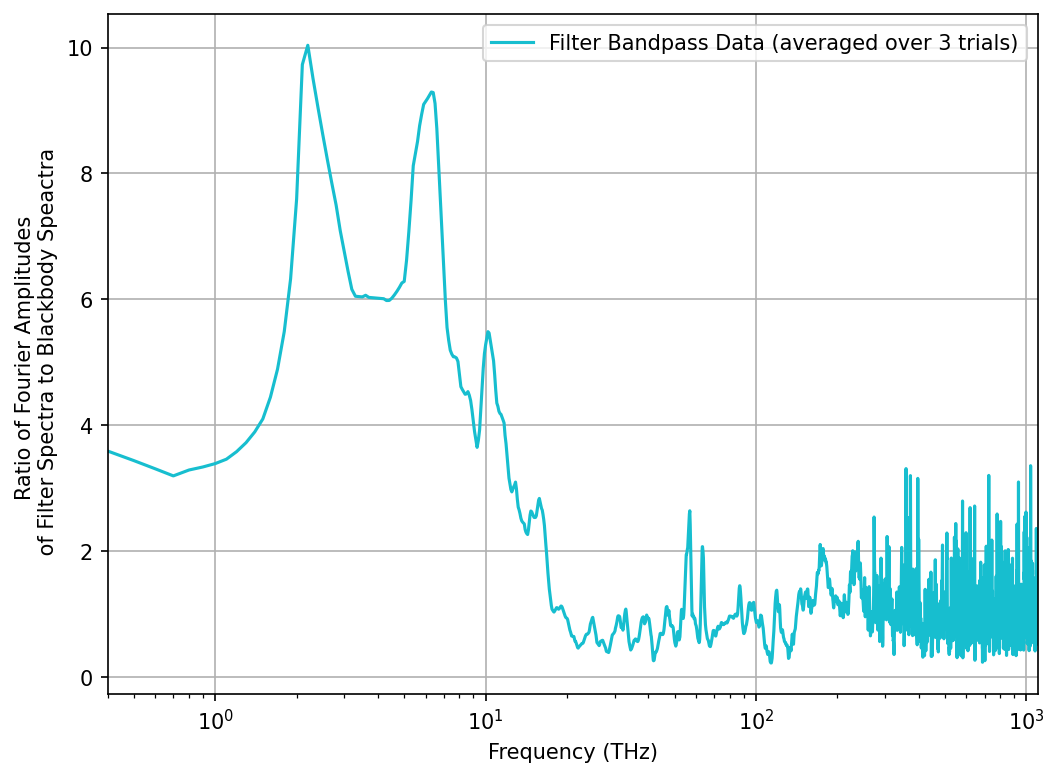

In [152]:
#########plot of filter transmittance#############
#### interpolate the transform! to make sure we can divide out the different arrays
interpolate_isopropanol_bag_1 = interp1d(frequency_isopropanol_bagfilter_1, spectrum_isopropanol_bagfilter_1, fill_value='extrapolate')
interpolate_isopropanol_bag_2 = interp1d(frequency_isopropanol_bagfilter_2, spectrum_isopropanol_bagfilter_2, fill_value='extrapolate')
interpolate_isopropanol_bag_3 = interp1d(frequency_isopropanol_bagfilter_3, spectrum_isopropanol_bagfilter_3, fill_value='extrapolate')

frequency_array = np.arange(0.1,1100, 0.1)

average_isopropanol_bag= [mean(i) for i in zip(interpolate_isopropanol_bag_1(frequency_array), interpolate_isopropanol_bag_2(frequency_array), interpolate_isopropanol_bag_3(frequency_array))]
ratio_transform =  np.array(average_isopropanol_bag)/np.array(average_nofilter)

fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data (averaged over 3 trials)", color='C9')
if jog_adjustment:
  title = "Bandpass of Plastic Bag filled with isopropanol as Optical Filter \n Interferometer Signal, with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "Bandpass of Plastic Bag filled with isopropanol as Optical Filter \n Interferometer Signal"

plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlim(4e-1, 1100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")

In [153]:
L = mm_to_micron * jog_dist* len(power_averaged_Si253_1650nmBandPassFilter_9V)
dx = -1 * L/2
x_simulated_1650nmBandPass_filter, y_simulated_1650nmBandPass_filter, weights, filter_val_1650nmBandPass = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='narrow_1650', dx=dx, L=L, dL=dL,  Temp=get_temp(9)) #blackbody background
x_simulated_nofilter, y_simulated_nofilter_unscaled, weights_nofilter = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(9))

In [154]:
scale_weight = 5e-4
scale_weight_bandpass = 5e-3
sigma_bandpass = scale_weight_bandpass * noise_to_signal_ratio
add_weight = 1e-7
sigma = scale_weight*noise_to_signal_ratio
add_weight_1650nmBandPass = 1e-6
y_simulated_1650nmBandPass = scale_weight_bandpass*y_simulated_1650nmBandPass_filter + np.random.rand(len(x_simulated_1650nmBandPass_filter))*sigma_bandpass + add_weight
frequency_simulated_1650nmBandPass, spectrum_simulated1650nmBandPass = psd_frequency(y_simulated_1650nmBandPass, 'parzen')

y_simulated_nofilter = scale_weight*y_simulated_nofilter_unscaled + np.random.rand(len(x_simulated_nofilter))*sigma + add_weight
frequency_simulated_nofilter, spectrum_simulated_nofilter = psd_frequency(y_simulated_nofilter, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


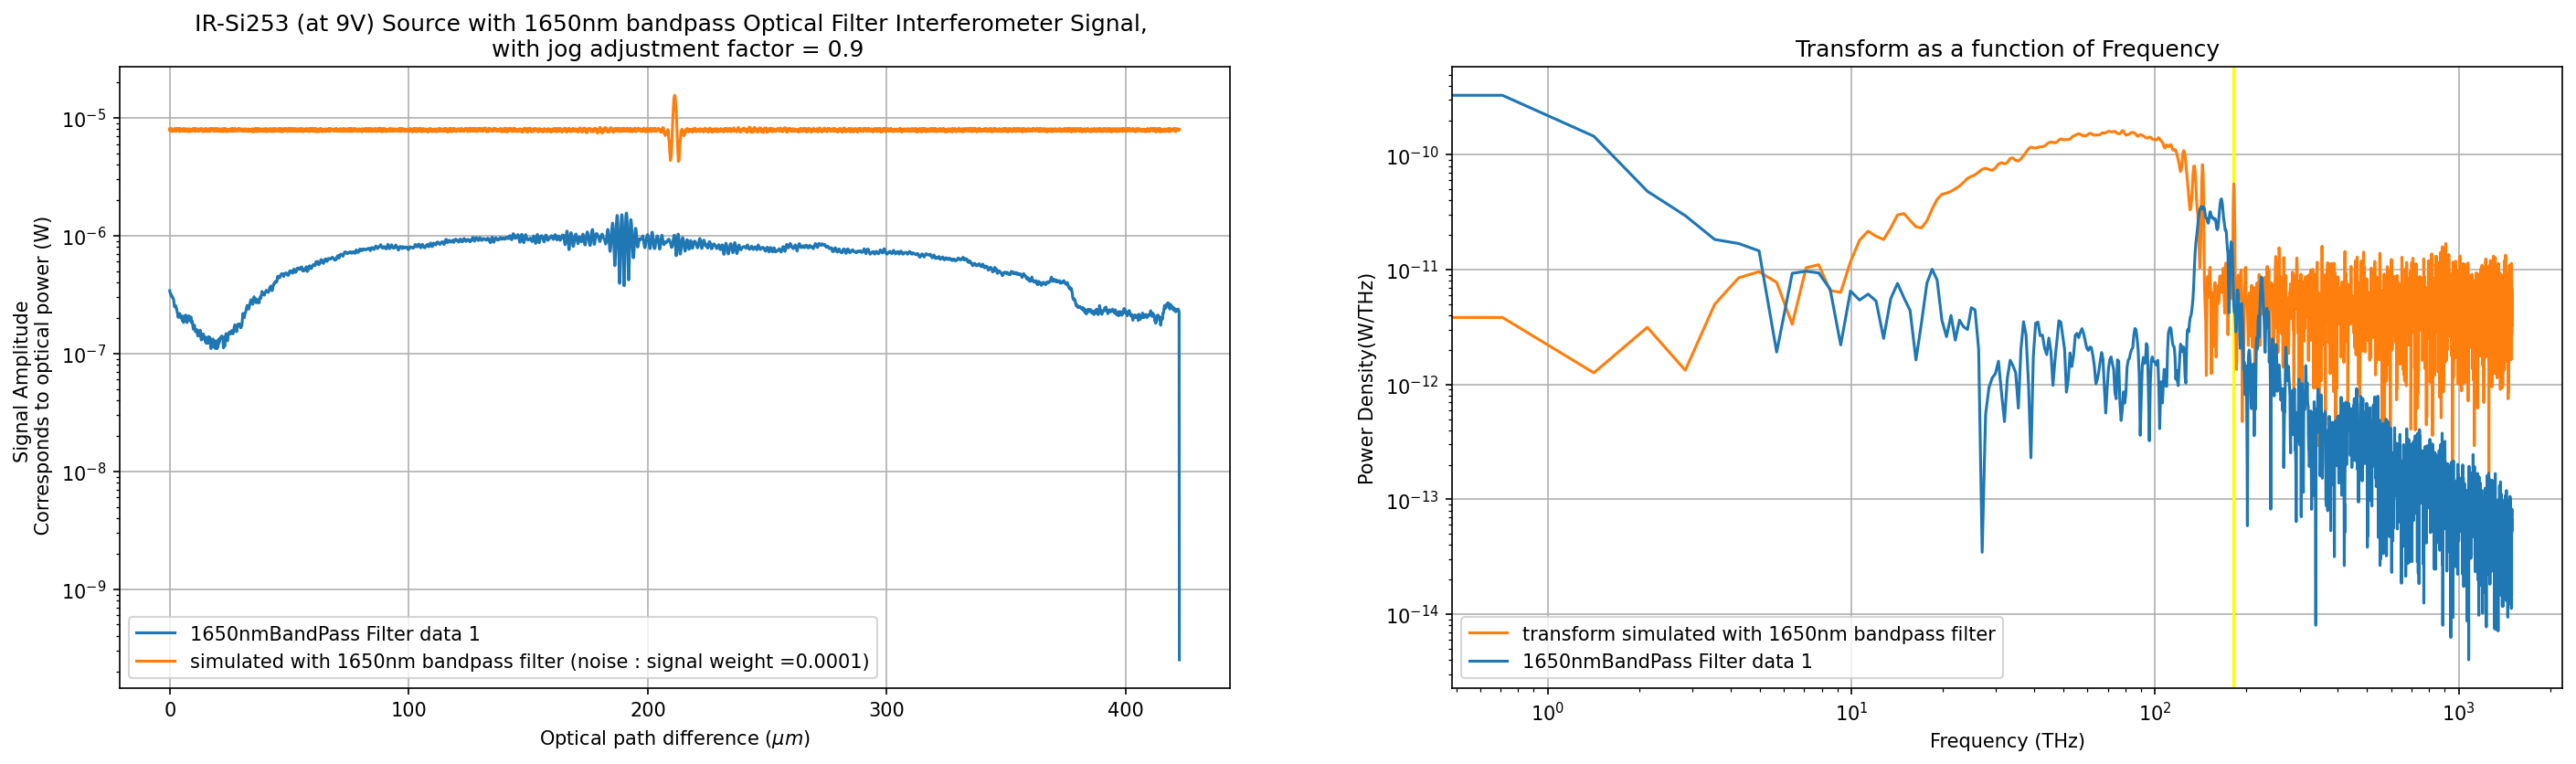

In [155]:
plot_nofilter = False
######generate x and y for plots ########
x_1650nmBandPass_1, y_1650nmBandPass_1 = generate_xy_plot(power_averaged_Si253_1650nmBandPassFilter_9V)

######## get transforms for y values ######
frequency_1650nmBandPassfilter_1, spectrum_1650nmBandPassfilter_1 = psd_frequency(y_1650nmBandPass_1, 'parzen', fs)
frequency_nofilter_0, spectrum_nofilter_0 = psd_frequency(y_nofilter_0, 'parzen', fs)
frequency_nofilter_1, spectrum_nofilter_1 = psd_frequency(y_nofilter_1, 'parzen', fs)
frequency_nofilter_2, spectrum_nofilter_2 = psd_frequency(y_nofilter_2, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
plt.plot(x_1650nmBandPass_1, y_1650nmBandPass_1,   label = '1650nmBandPass Filter data 1', color='C0')
plt.plot(x_simulated_1650nmBandPass_filter, y_simulated_1650nmBandPass ,label= "simulated with 1650nm bandpass filter (noise : signal weight ="+ str(noise_to_signal_ratio) +")", color='C1')

if plot_nofilter:
  plt.errorbar(x_nofilter_0, y_nofilter_0, power_error_Si253_noFilter_0, label = 'No Filter data 0', color='springgreen')
  plt.errorbar(x_nofilter_1, y_nofilter_1, power_error_Si253_noFilter, label = 'No Filter data 1', color='C2')
  plt.errorbar(x_nofilter_2, y_nofilter_2, power_error_Si253_noFilter_2, label = 'No Filter data 1', color='green')
  

########### transform plot ##############
plt.subplot(1,2,2)
plt.axvline(x=181.6, color = 'yellow')
plt.semilogy(frequency_simulated_1650nmBandPass, spectrum_simulated1650nmBandPass, label='transform simulated with 1650nm bandpass filter', color='C1')
plt.semilogy(frequency_1650nmBandPassfilter_1, spectrum_1650nmBandPassfilter_1, label='1650nmBandPass Filter data 1', color='C0')
if plot_nofilter:
  plt.semilogy(frequency_nofilter_0, spectrum_nofilter_0, label='No Filter data 0', color='springgreen')
  plt.semilogy(frequency_nofilter_1, spectrum_nofilter_1, label='No Filter data 1', color='C2')
  plt.semilogy(frequency_nofilter_2, spectrum_nofilter_2, label='No Filter data 2', color='green')
  plt.semilogy(frequency_simulated_nofilter, spectrum_simulated_nofilter, '--', label='transform simulated without filter', color='peru')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
if jog_adjustment:
  title = "IR-Si253 (at 9V) Source with 1650nm bandpass Optical Filter Interferometer Signal, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 (at 9V) Source with 1650nm bandpass Optical Filter Interferometer Signal"

plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')


plt.show()

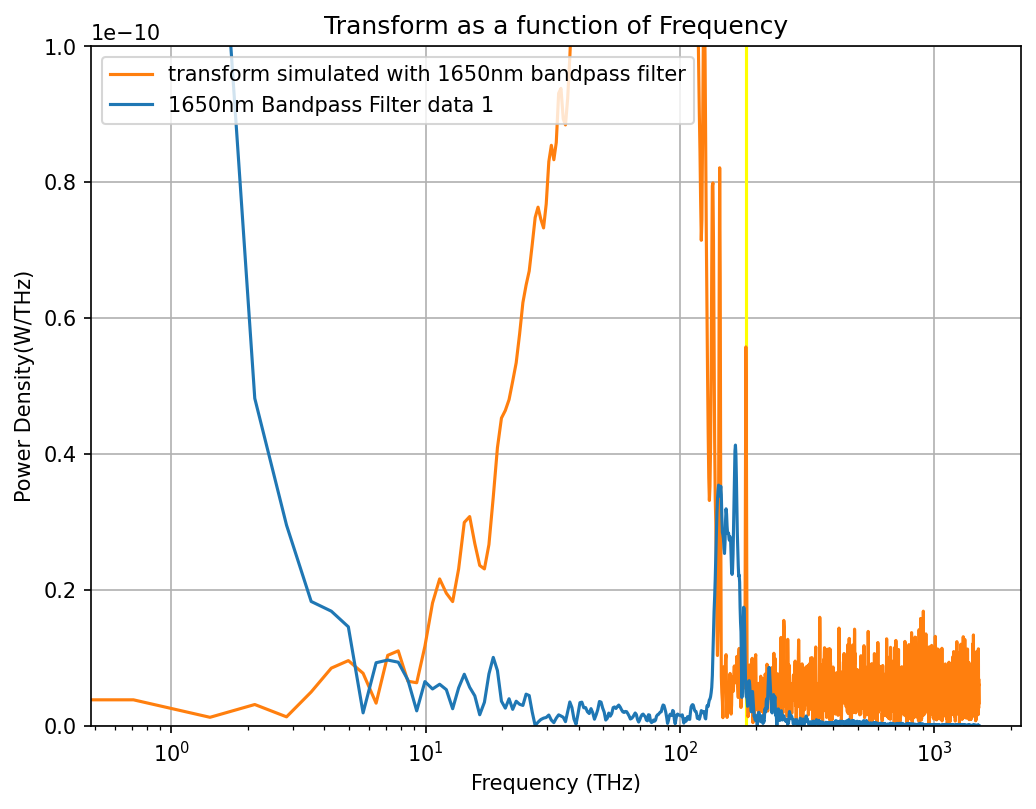

In [156]:
########## start plotting! ############
fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.axvline(x=181.6, color = 'yellow')
plt.plot(frequency_simulated_1650nmBandPass, spectrum_simulated1650nmBandPass, label='transform simulated with 1650nm bandpass filter', color='C1')
plt.plot(frequency_1650nmBandPassfilter_1, spectrum_1650nmBandPassfilter_1, label='1650nm Bandpass Filter data 1', color='C0')

plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')

plt.ylim(0,1e-10)
plt.show()

Text(0, 0.5, 'Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra')

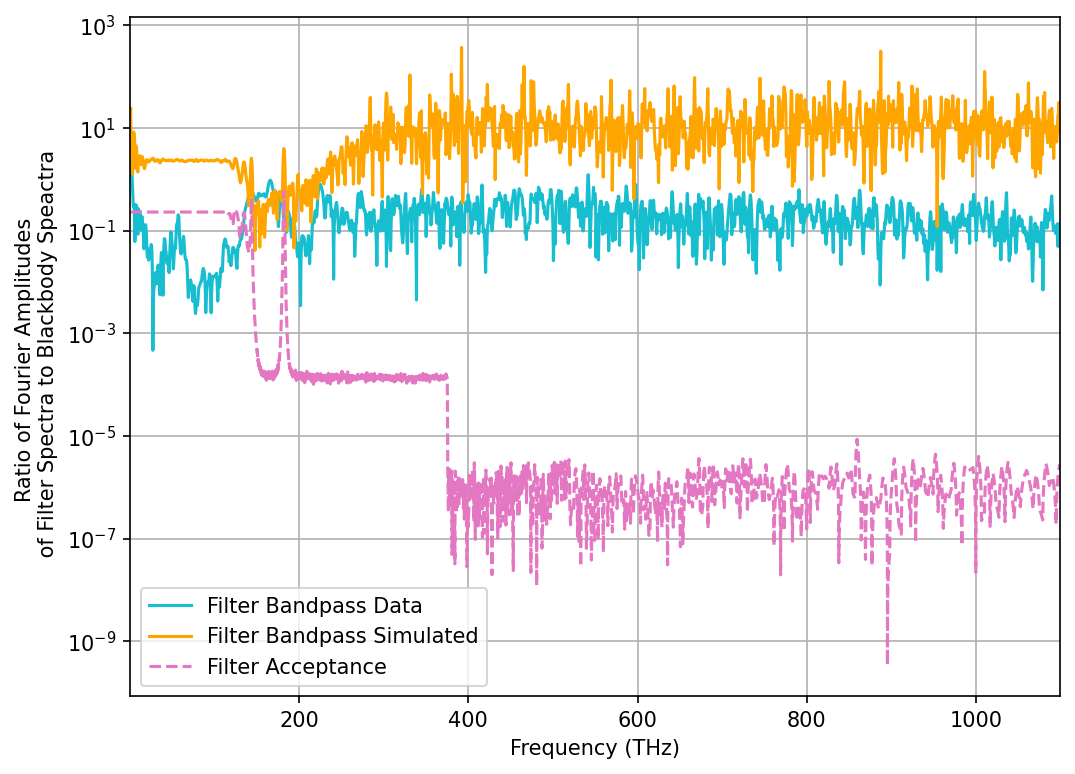

In [157]:
#########plot of filter transmittance#############
#### interpolate the transform! to make sure we can divide out the different arrays
interpolate_1650nmBandPass_1 = interp1d(frequency_1650nmBandPassfilter_1, spectrum_1650nmBandPassfilter_1, fill_value='extrapolate')
interpolate_nofilter_0 = interp1d(frequency_nofilter_0, spectrum_nofilter_0, fill_value='extrapolate')
interpolate_nofilter_1 = interp1d(frequency_nofilter_1, spectrum_nofilter_1, fill_value='extrapolate')
interpolate_nofilter_2 = interp1d(frequency_nofilter_2, spectrum_nofilter_2, fill_value='extrapolate')

frequency_array = np.arange(0.1,1100, 0.1)

average_1650nmBandPass = [mean(i) for i in zip(interpolate_1650nmBandPass_1(frequency_array))]
average_nofilter = [mean(i) for i in zip(interpolate_nofilter_0(frequency_array),interpolate_nofilter_1(frequency_array), interpolate_nofilter_2(frequency_array))]
ratio_transform =  np.array(average_1650nmBandPass)/np.array(average_nofilter)


fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data", color='C9')
plt.plot(frequency_simulated_nofilter, spectrum_simulated1650nmBandPass/spectrum_simulated_nofilter, label = "Filter Bandpass Simulated", color='orange')
plt.plot(frequencies, filter_val_1650nmBandPass, '--', label = 'Filter Acceptance', color='C6')

if jog_adjustment:
  title = "1650nm Bandpass Filter as a function of Frequency, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "1650nm Bandpass Filter as a function of Frequency"
plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.grid(True)
plt.xlim(4e-1, 1100)
plt.xlabel('Frequency (THz)')
plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")

Text(0.5, 1.0, 'Blackbody Weights Modfied to show Filter 1650 nm Bandpass')

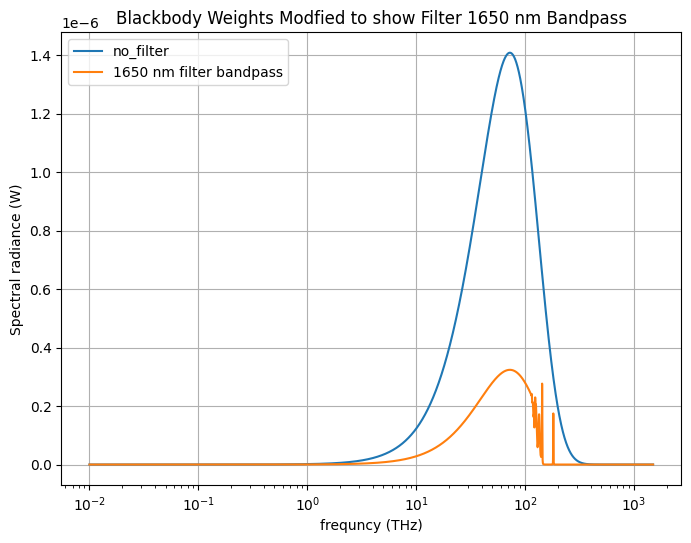

In [158]:
fig = plt.figure(figsize=(8, 6), dpi=100) 
plt.plot(frequencies, weights_nofilter, color='C0', label = 'no_filter')
plt.plot(frequencies, weights,  color='C1', label = '1650 nm filter bandpass')
plt.xscale('log')
plt.xlabel('frequncy (THz)')
plt.ylabel('Spectral radiance (W)')
plt.legend()
plt.grid()
plt.title("Blackbody Weights Modfied to show Filter 1650 nm Bandpass")

### Plots to show the change of distribution as we change the input voltage (therefore chaning the temperature of the blackbody)

In [159]:
L = mm_to_micron * jog_dist* len(power_error_Si253_nofilter_3V)
dx = -1*L/2
x_simulated_nofilter_3v, y_simulated_nofilter_3v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(3))
x_simulated_nofilter_4v, y_simulated_nofilter_4v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(4))
x_simulated_nofilter_5v, y_simulated_nofilter_5v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(5))
x_simulated_nofilter_6v, y_simulated_nofilter_6v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(6))
x_simulated_nofilter_7v, y_simulated_nofilter_7v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(7))
x_simulated_nofilter_8v, y_simulated_nofilter_8v, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter='no', dx=dx, L=L, dL=dL, Temp=get_temp(8))

scale_weight = 5e-2
add_weight = 1e-5
sigma = scale_weight*noise_to_signal_ratio

y_simulated_nofilter_3v = scale_weight*y_simulated_nofilter_3v + np.random.rand(len(x_simulated_nofilter_3v))*sigma + add_weight
frequency_simulated_nofilter_3v, spectrum_simulated_nofilter_3v = psd_frequency(y_simulated_nofilter_3v, 'parzen')

y_simulated_nofilter_4v = scale_weight*y_simulated_nofilter_4v + np.random.rand(len(x_simulated_nofilter_4v))*sigma + add_weight
frequency_simulated_nofilter_4v, spectrum_simulated_nofilter_4v = psd_frequency(y_simulated_nofilter_4v, 'parzen')

y_simulated_nofilter_5v = scale_weight*y_simulated_nofilter_5v + np.random.rand(len(x_simulated_nofilter_5v))*sigma + add_weight
frequency_simulated_nofilter_5v, spectrum_simulated_nofilter_5v = psd_frequency(y_simulated_nofilter_5v, 'parzen')

y_simulated_nofilter_6v = scale_weight*y_simulated_nofilter_6v + np.random.rand(len(x_simulated_nofilter_6v))*sigma + add_weight
frequency_simulated_nofilter_6v, spectrum_simulated_nofilter_6v = psd_frequency(y_simulated_nofilter_6v, 'parzen')

y_simulated_nofilter_7v = scale_weight*y_simulated_nofilter_7v + np.random.rand(len(x_simulated_nofilter_7v))*sigma + add_weight
frequency_simulated_nofilter_7v, spectrum_simulated_nofilter_7v = psd_frequency(y_simulated_nofilter_7v, 'parzen')

y_simulated_nofilter_8v = scale_weight*y_simulated_nofilter_8v + np.random.rand(len(x_simulated_nofilter_8v))*sigma + add_weight
frequency_simulated_nofilter_8v, spectrum_simulated_nofilter_8v = psd_frequency(y_simulated_nofilter_8v, 'parzen')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


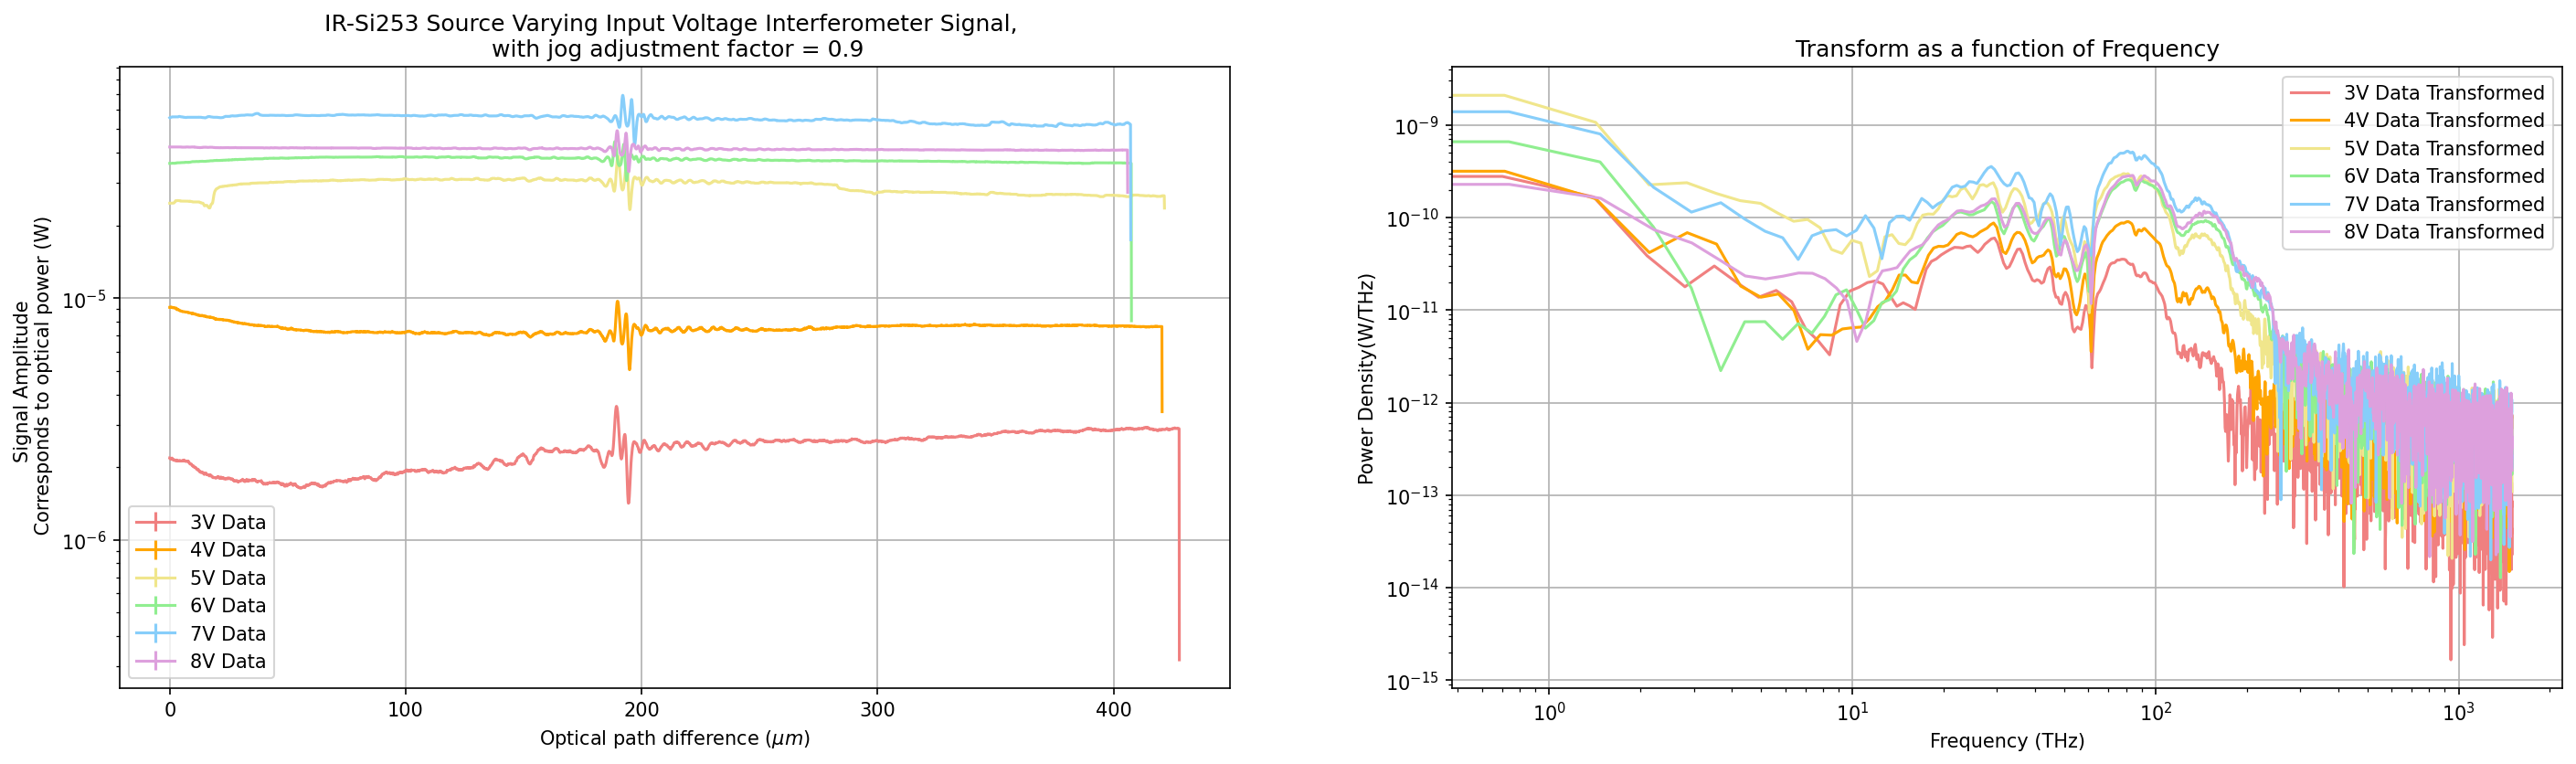

In [160]:
plot_simulation = False
######generate x and y for plots ########
x_nofilter_3v, y_nofilter_3v = generate_xy_plot(power_averaged_Si253__nofilter_3V)
x_nofilter_4v, y_nofilter_4v = generate_xy_plot(power_averaged_Si253__nofilter_4V)
x_nofilter_5v, y_nofilter_5v = generate_xy_plot(power_averaged_Si253__nofilter_5V)
x_nofilter_6v, y_nofilter_6v = generate_xy_plot(power_averaged_Si253__nofilter_6V)
x_nofilter_7v, y_nofilter_7v = generate_xy_plot(power_averaged_Si253__nofilter_7V)
x_nofilter_8v, y_nofilter_8v = generate_xy_plot(power_averaged_Si253__nofilter_8V)

######## get transforms for y values #####
frequency_nofilter_3v, spectrum_nofilter_3v = psd_frequency(y_nofilter_3v, 'parzen', fs)
frequency_nofilter_4v, spectrum_nofilter_4v = psd_frequency(y_nofilter_4v, 'parzen', fs)
frequency_nofilter_5v, spectrum_nofilter_5v = psd_frequency(y_nofilter_5v, 'parzen', fs)
frequency_nofilter_6v, spectrum_nofilter_6v = psd_frequency(y_nofilter_6v, 'parzen', fs)
frequency_nofilter_7v, spectrum_nofilter_7v = psd_frequency(y_nofilter_7v, 'parzen', fs)
frequency_nofilter_8v, spectrum_nofilter_8v = psd_frequency(y_nofilter_8v, 'parzen', fs)

########## start plotting! ############
fig = plt.figure(figsize=(23, 6), dpi=150)  

###### displacment vs optical signal plot ##########
plt.subplot(1, 2, 1)
plt.errorbar(x_nofilter_3v, y_nofilter_3v, power_error_Si253_nofilter_3V , label = '3V Data', color = "lightcoral")
plt.errorbar(x_nofilter_4v, y_nofilter_4v, power_error_Si253_nofilter_4V , label = '4V Data', color = "orange")
plt.errorbar(x_nofilter_5v, y_nofilter_5v, power_error_Si253_nofilter_5V , label = '5V Data', color = "khaki")
plt.errorbar(x_nofilter_6v, y_nofilter_6v, power_error_Si253_nofilter_6V , label = '6V Data', color = "lightgreen")
plt.errorbar(x_nofilter_7v, y_nofilter_7v, power_error_Si253_nofilter_7V , label = '7V Data', color = "lightskyblue")
plt.errorbar(x_nofilter_8v, y_nofilter_8v, power_error_Si253_nofilter_8V , label = '8V Data', color = "plum")
if plot_simulation:
  plt.plot(x_simulated_nofilter_3v, y_simulated_nofilter_3v, label= "3V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='indianred')
  plt.plot(x_simulated_nofilter_4v, y_simulated_nofilter_4v, label= "4V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='darkorange')
  plt.plot(x_simulated_nofilter_5v, y_simulated_nofilter_5v, label= "5V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='gold')
  plt.plot(x_simulated_nofilter_6v, y_simulated_nofilter_6v, label= "6V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='limegreen')
  plt.plot(x_simulated_nofilter_7v, y_simulated_nofilter_7v, label= "7V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='steelblue')
  plt.plot(x_simulated_nofilter_8v, y_simulated_nofilter_8v, label= "8V Simulated (noise : signal weight ="+ str(noise_to_signal_ratio) +")",  color='darkorchid')


########### transform plot ##############
plt.subplot(1,2,2)
plt.plot(frequency_nofilter_3v, spectrum_nofilter_3v, label='3V Data Transformed', color = "lightcoral")
plt.plot(frequency_nofilter_4v, spectrum_nofilter_4v, label='4V Data Transformed', color = "orange")
plt.plot(frequency_nofilter_5v, spectrum_nofilter_5v, label='5V Data Transformed', color = "khaki")
plt.plot(frequency_nofilter_6v, spectrum_nofilter_6v, label='6V Data Transformed', color = "lightgreen")
plt.plot(frequency_nofilter_7v, spectrum_nofilter_7v, label='7V Data Transformed', color = "lightskyblue")
plt.plot(frequency_nofilter_8v, spectrum_nofilter_8v, label='8V Data Transformed', color = "plum")
if plot_simulation: 
  plt.plot(frequency_simulated_nofilter_3v, spectrum_simulated_nofilter_3v, '--', label='3V Simulation Transformed',  color='indianred')
  plt.plot(frequency_simulated_nofilter_4v, spectrum_simulated_nofilter_4v, '--', label='4V Simulation Transformed',  color='darkorange')
  plt.plot(frequency_simulated_nofilter_5v, spectrum_simulated_nofilter_5v, '--', label='5V Simulation Transformed',  color='gold')
  plt.plot(frequency_simulated_nofilter_6v, spectrum_simulated_nofilter_6v, '--', label='6V Simulation Transformed',  color='limegreen')
  plt.plot(frequency_simulated_nofilter_7v, spectrum_simulated_nofilter_7v, '--', label='7V Simulation Transformed',  color='steelblue')
  plt.plot(frequency_simulated_nofilter_8v, spectrum_simulated_nofilter_8v, '--', label='8V Simulation Transformed',  color='darkorchid')

#plot details for blackbody spectrum plot
plt.subplot(1, 2, 1)
plt.grid(True)
if jog_adjustment:
  title = "IR-Si253 Source Varying Input Voltage Interferometer Signal, \n with jog adjustment factor = " +  str(jog_adjustment_value)
else: 
  title = "IR-Si253 Source Varying Input Voltage Interferometer Signal"
plt.title(title)
plt.legend()
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")
plt.yscale('log')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(1, 2, 2)
plt.title("Transform as a function of Frequency")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')
plt.yscale('log')

plt.show()

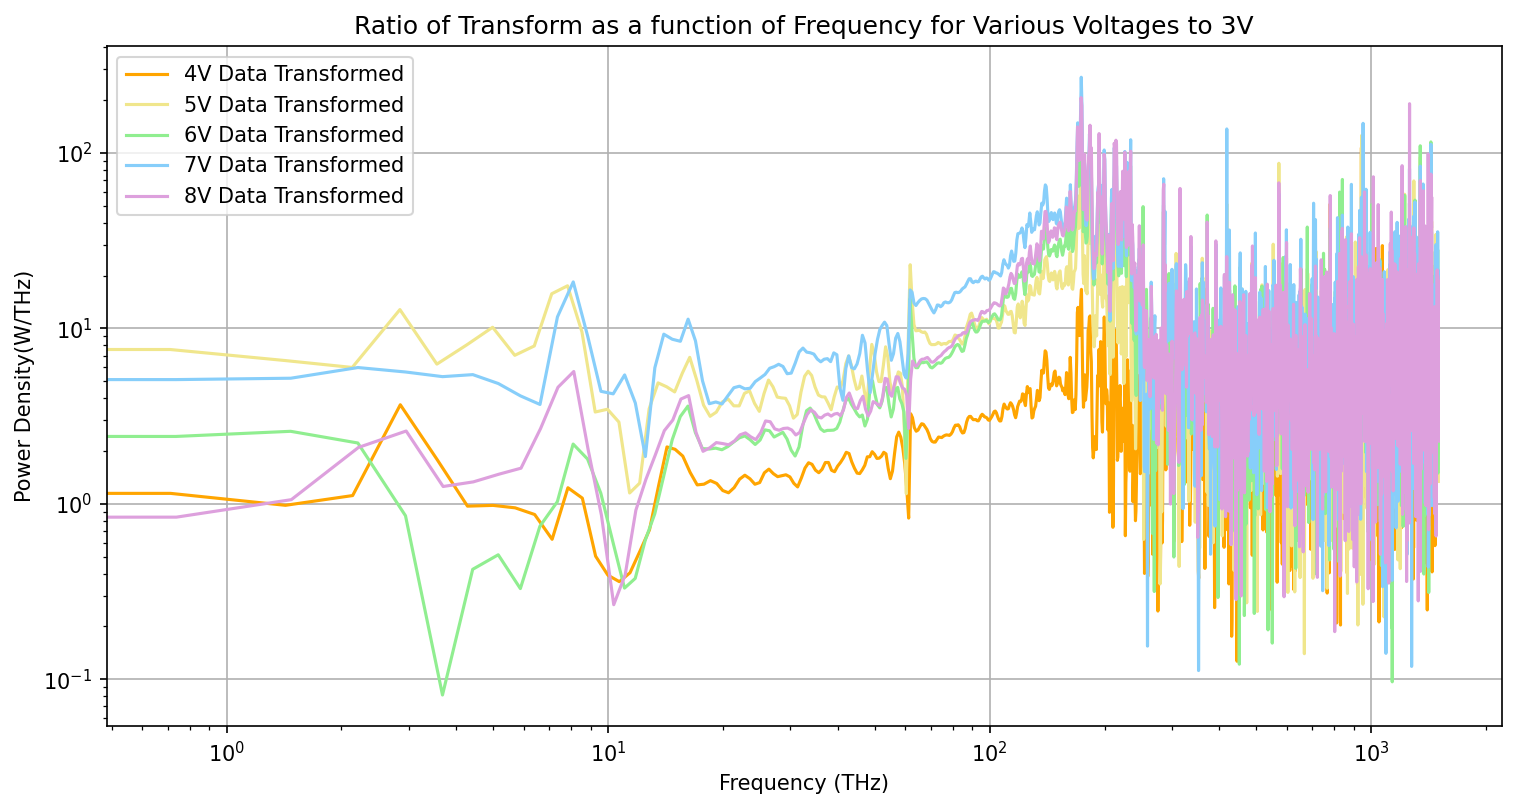

In [161]:
interpolate_3v = interp1d(frequency_nofilter_3v, spectrum_nofilter_3v, fill_value='extrapolate')
plot_simulation = False

########## start plotting! ############
fig = plt.figure(figsize=(12, 6), dpi=150)  

########### transform plot ##############
plt.plot(frequency_nofilter_4v, spectrum_nofilter_4v/interpolate_3v(frequency_nofilter_4v), label='4V Data Transformed', color = "orange")
plt.plot(frequency_nofilter_5v, spectrum_nofilter_5v/interpolate_3v(frequency_nofilter_5v), label='5V Data Transformed', color = "khaki")
plt.plot(frequency_nofilter_6v, spectrum_nofilter_6v/interpolate_3v(frequency_nofilter_6v), label='6V Data Transformed', color = "lightgreen")
plt.plot(frequency_nofilter_7v, spectrum_nofilter_7v/interpolate_3v(frequency_nofilter_7v), label='7V Data Transformed', color = "lightskyblue")
plt.plot(frequency_nofilter_8v, spectrum_nofilter_8v/interpolate_3v(frequency_nofilter_8v), label='8V Data Transformed', color = "plum")
if plot_simulation: 
  plt.plot(frequency_simulated_nofilter_4v, spectrum_simulated_nofilter_4v/spectrum_simulated_nofilter_3v, '--', label='4V Simulation Transformed',  color='darkorange')
  plt.plot(frequency_simulated_nofilter_5v, spectrum_simulated_nofilter_5v/spectrum_simulated_nofilter_3v, '--', label='5V Simulation Transformed',  color='gold')
  plt.plot(frequency_simulated_nofilter_6v, spectrum_simulated_nofilter_6v/spectrum_simulated_nofilter_3v, '--', label='6V Simulation Transformed',  color='limegreen')
  plt.plot(frequency_simulated_nofilter_7v, spectrum_simulated_nofilter_7v/spectrum_simulated_nofilter_3v, '--', label='7V Simulation Transformed',  color='steelblue')
  plt.plot(frequency_simulated_nofilter_8v, spectrum_simulated_nofilter_8v/spectrum_simulated_nofilter_3v, '--', label='8V Simulation Transformed',  color='darkorchid')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.title("Ratio of Transform as a function of Frequency for Various Voltages to 3V")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
plt.xscale('log')
plt.yscale('log')

plt.show()

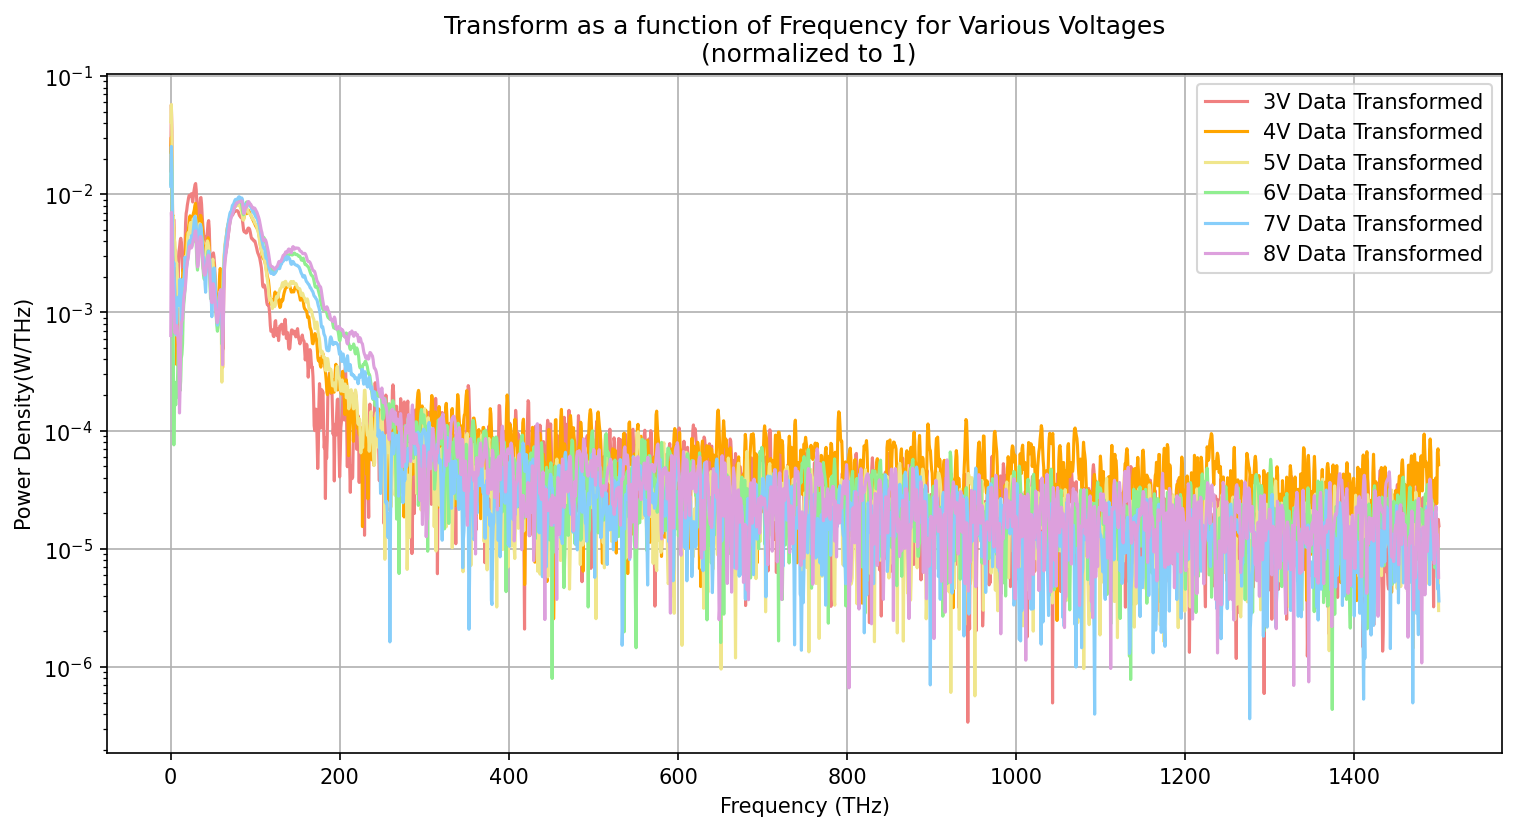

In [162]:
#### interpolate the transform! to make sure we can divide out the different arrays

plot_simulation = False
########## start plotting! ############
fig = plt.figure(figsize=(12, 6), dpi=150)  

########### transform plot ##############
plt.plot(frequency_nofilter_3v, spectrum_nofilter_3v/sum(spectrum_nofilter_3v), label='3V Data Transformed', color = "lightcoral")
plt.plot(frequency_nofilter_4v, spectrum_nofilter_4v/sum(spectrum_nofilter_4v), label='4V Data Transformed', color = "orange")
plt.plot(frequency_nofilter_5v, spectrum_nofilter_5v/sum(spectrum_nofilter_5v), label='5V Data Transformed', color = "khaki")
plt.plot(frequency_nofilter_6v, spectrum_nofilter_6v/sum(spectrum_nofilter_6v), label='6V Data Transformed', color = "lightgreen")
plt.plot(frequency_nofilter_7v, spectrum_nofilter_7v/sum(spectrum_nofilter_7v), label='7V Data Transformed', color = "lightskyblue")
plt.plot(frequency_nofilter_8v, spectrum_nofilter_8v/sum(spectrum_nofilter_8v), label='8V Data Transformed', color = "plum")
if plot_simulation: 
  plt.plot(frequency_simulated_nofilter_3v, spectrum_simulated_nofilter_3v/sum(spectrum_simulated_nofilter_3v), '--', label='3V Simulation Transformed',  color='indianred')
  plt.plot(frequency_simulated_nofilter_4v, spectrum_simulated_nofilter_4v/sum(spectrum_simulated_nofilter_4v), '--', label='4V Simulation Transformed',  color='darkorange')
  plt.plot(frequency_simulated_nofilter_5v, spectrum_simulated_nofilter_5v/sum(spectrum_simulated_nofilter_5v), '--', label='5V Simulation Transformed',  color='gold')
  plt.plot(frequency_simulated_nofilter_6v, spectrum_simulated_nofilter_6v/sum(spectrum_simulated_nofilter_6v), '--', label='6V Simulation Transformed',  color='limegreen')
  plt.plot(frequency_simulated_nofilter_7v, spectrum_simulated_nofilter_7v/sum(spectrum_simulated_nofilter_7v), '--', label='7V Simulation Transformed',  color='steelblue')
  plt.plot(frequency_simulated_nofilter_8v, spectrum_simulated_nofilter_8v/sum(spectrum_simulated_nofilter_8v), '--', label='8V Simulation Transformed',  color='darkorchid')

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.title(" Transform as a function of Frequency for Various Voltages \n (normalized to 1)")
plt.legend()
plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel("Power Density(W/THz)")
#plt.xscale('log')
plt.yscale('log')

plt.show()